# Exercise for data science candidates - CytoReason




In [4]:
# packages 

import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt # import matplotlib to visualize 
import plotly.express as px
from pca import pca
from IPython import display

from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler

import gc
%matplotlib inline 


## Exercise Part 1: Data exploration 

“A strange disease has spread across the land, many people seem to be affected in a way that is yet to be understood: when they are in daylight, odd looking marks appears on their skin that appear like burning tissue...
A drug company trying to help these poor sick people, named “Pharmacom”, has contacted you as an expert. They have extracted paired groups (normal and lesion) biopsy samples from multiple individuals and subjects them to whole genome RNA-seq mRNA profiling in the hope that you’ll be able to tell them what is going on.”


**In this part we used three files:**

* Gene-level raw count matrix (counts.txt)

* Sample annotation file (sample-annotation.txt)

* Gene annotation file (gene-annotation.txt)

### 1.Load the data and make sure the count and annotation data are consistent with each other.



In [2]:
# Load the Gene-level raw count matrix 
# each line is the gene and row is the sample (normal/lesianal)
counts_df= pd.read_csv('counts.txt',sep='\t' , index_col=0) 
counts_df.head()

SRR1146076  SRR1146077  SRR1146078  SRR1146079  SRR1146080   
ENSG00000000003         605         372         118         327         515  \
ENSG00000000005         254           7          33          10          60   
ENSG00000000419         556         560         493         623         913   
ENSG00000000457         530         376         184         604         407   
ENSG00000000460         218         179          85         278         267   

                 SRR1146081  SRR1146082  SRR1146083  SRR1146084  SRR1146085   
ENSG00000000003         456         532         611         721         913  \
ENSG00000000005          19          76          10          44          52   
ENSG00000000419         703        1996        1169        1407         903   
ENSG00000000457         516         721         570         711         864   
ENSG00000000460         278         339         357         439         343   

                 ...  SRR1146244  SRR1146245  SRR1146246  SRR1146247   
ENSG00000000003  ...         546         744         901         829  \
ENSG00000000005  ...          25          55          57          51   
ENSG00000000419  ...         706         659         933         784   
ENSG00000000457  ...         572         596         523         590   
ENSG00000000460  ...         219         240         237         236   

                 SRR1146248  SRR1146249  SRR1146250  SRR1146252  SRR1146253   
ENSG00000000003         526         426         513         464         421  \
ENSG00000000005          28          66          55          45          13   
ENSG00000000419         599         630         709         698         903   
ENSG00000000457         547         594         707         457         309   
ENSG00000000460         218         217         282         274         210   

                 SRR1146254  
ENSG00000000003         619  
ENSG00000000005          37  
ENSG00000000419        1097  
ENSG00000000457         563  
ENSG00000000460         289  

[5 rows x 178 columns]

In [3]:
# Load sample annotation file
sample_df= pd.read_csv('sample-annotation.txt', sep='\t',index_col=0) 
sample_df.columns
sample_df.head()

type
sample_id           
SRR1146076    normal
SRR1146077  lesional
SRR1146078  lesional
SRR1146079  lesional
SRR1146080  lesional

In [4]:
# convert the type cell to binary values (normal-1 lesional-0)

label_binarizer = LabelBinarizer()
sample_df['binary_type'] = label_binarizer.fit_transform( sample_df['type'])

sample_df.head() 


type  binary_type
sample_id                        
SRR1146076    normal            1
SRR1146077  lesional            0
SRR1146078  lesional            0
SRR1146079  lesional            0
SRR1146080  lesional            0

In [5]:
# Load the gene annotation file 
gene_df= pd.read_csv('gene-annotation.txt',sep='\t',index_col=0) 
gene_df.index.names=[None] # remove the name  
gene_df.head()

ENTREZID    SYMBOL   
ENSG00000000003      7105    TSPAN6  \
ENSG00000000005     64102      TNMD   
ENSG00000000419      8813      DPM1   
ENSG00000000457     57147     SCYL3   
ENSG00000000460     55732  C1orf112   

                                                          GENENAME  
ENSG00000000003                                      tetraspanin 6  
ENSG00000000005                                        tenomodulin  
ENSG00000000419  dolichyl-phosphate mannosyltransferase subunit...  
ENSG00000000457                           SCY1 like pseudokinase 3  
ENSG00000000460                chromosome 1 open reading frame 112

We need to check that we have same amount of gene and samples


In [6]:
# check that we have the same number of genes and samples in the count matrix file and annotation files
if (gene_df.index.nunique()== counts_df.index.nunique()) and (sample_df.index.nunique()==counts_df.column.nunique()):
    print(f' The Gene-level matrix shape is: {counts_df.shape}, and unique number of Gene is:{counts_df.index.nunique()} the unique number of Samle is:{counts_df.columns.nunique()} \
          \n The Sample annotation shape is:{sample_df.shape}, The unique number of Sample is:{sample_df.index.nunique()}\
              \n The Gene annotation shape is {gene_df.shape}, The unique number of Gene os:{gene_df.index.nunique()}' )
else:
    print ('The data is not consistent with each other ')
    print(f' The Gene-level matrix shape is: {counts_df.shape}, The unique number of Gene is: {counts_df.index.nunique()} the unique number of Sample is: {counts_df.columns.nunique()} \
          \n The Sample annotation shape is: {sample_df.shape}, The unique number of Sample is: {sample_df.index.nunique()}\
              \n The Gene annotation shape is: {gene_df.shape}, The unique number of Gene os: {gene_df.index.nunique()}' )
   

The data is not consistent with each other 
 The Gene-level matrix shape is: (57992, 178), The unique number of Gene is: 57992 the unique number of Sample is: 178           
 The Sample annotation shape is: (178, 2), The unique number of Sample is: 178              
 The Gene annotation shape is: (25503, 3), The unique number of Gene os: 25503


**Conclution**

The number of genes in the Gene-label matrix (57,992) is higher than in the Gene annotation file (25,503).

There is no duplicity in Genes.

The number of samples is the same in the Sample annotation and in the Gene-level matrix (178).

### 2. Generate an object that contains the library-size normalized (CPM). 
For each feature 𝑖, the CPM is the count of sequenced fragments mapping to the feature (𝑟𝑖) scaled by the total number of reads (𝑅) times one million.

\begin{gather*}
CMP_i=\frac {r_i}{R}10^6\\
\end{gather*}



 **This function normalizes the count data present in a given matrix using counts per million normalization (CPM).** 

 **Each gene count for each cell is divided by the total counts for that cell and multiplied by 1e6.**

##### **Each gene count for each cell is divided by the total counts for that cell and multiplied by 1e6.**

In [7]:
def CPM_function(df_notnorm_CMP):
    '''
    This function normalizes the count data present in a given matrix using counts per million normalization (CPM).
    Each gene count for each cell is divided by the total counts for that cell and multiplied by 1e6.
    Input:
    ======
    df_notnorm_CMP : DataFrame 
    
    Output:
    =======
    df_norm_CPM: CPM normalization DataFrame
    
    '''
    df_norm_CPM=df_notnorm_CMP / df_notnorm_CMP.sum(axis = 0) * 1e6
    return(df_norm_CPM)
    

In [8]:
# Calculate the CMP 
CMP_df=CPM_function(counts_df)
CMP_df.head()

SRR1146076  SRR1146077  SRR1146078  SRR1146079  SRR1146080   
ENSG00000000003   15.288552    9.269803    2.882665    8.950436   13.405956  \
ENSG00000000005    6.418665    0.174432    0.806169    0.273714    1.561859   
ENSG00000000419   14.050306   13.954542   12.043676   17.052359   23.766286   
ENSG00000000457   13.393277    9.369478    4.495003   16.532303   10.594610   
ENSG00000000460    5.508933    4.460470    2.076496    7.609239    6.950272   

                 SRR1146081  SRR1146082  SRR1146083  SRR1146084  SRR1146085   
ENSG00000000003   11.384778   13.888903   15.416007   18.929201   24.098780  \
ENSG00000000005    0.474366    1.984129    0.252308    1.155180    1.372548   
ENSG00000000419   17.551533   52.109493   29.494783   36.939509   23.834829   
ENSG00000000457   12.882775   18.823119   14.381545   18.666660   22.805417   
ENSG00000000460    6.940720    8.850260    9.007389   11.525547    9.053540   

                 ...  SRR1146244  SRR1146245  SRR1146246  SRR1146247   
ENSG00000000003  ...   14.159007   18.959375   22.480744   20.897533  \
ENSG00000000005  ...    0.648306    1.401567    1.422200    1.285614   
ENSG00000000419  ...   18.308166   16.793318   23.279172   19.763167   
ENSG00000000457  ...   14.833245   15.187887   13.049311   14.872792   
ENSG00000000460  ...    5.679162    6.115928    5.913359    5.949117   

                 SRR1146248  SRR1146249  SRR1146250  SRR1146252  SRR1146253   
ENSG00000000003   13.516454   10.691960   13.518256   11.553249   10.486673  \
ENSG00000000005    0.719507    1.656501    1.449326    1.120466    0.323817   
ENSG00000000419   15.392311   15.812054   18.683125   17.379673   22.492793   
ENSG00000000457   14.056084   14.908508   18.630423   11.378955    7.696869   
ENSG00000000460    5.601876    5.446374    7.431088    6.822393    5.230882   

                 SRR1146254  
ENSG00000000003   15.662097  
ENSG00000000005    0.936183  
ENSG00000000419   27.756575  
ENSG00000000457   14.245170  
ENSG00000000460    7.312352  

[5 rows x 178 columns]

In [9]:
print(CMP_df.sum(axis = 0)) # sum of each cell is 1e6

SRR1146076    1000000.0
SRR1146077    1000000.0
SRR1146078    1000000.0
SRR1146079    1000000.0
SRR1146080    1000000.0
                ...    
SRR1146249    1000000.0
SRR1146250    1000000.0
SRR1146252    1000000.0
SRR1146253    1000000.0
SRR1146254    1000000.0
Length: 178, dtype: float64


In [10]:
# # Calculate the total numbe of reads (R)
# counts_df['CMP']=1e6*(counts_df.sum(axis=1)/sum(counts_df.sum(axis=1)))
# counts_df.head()

### 3. Filter the count data for lowly - expressed genes

Only keep genes with a CPM >= 1 in at least 75% samples, in at least one of the groups

In [11]:
# The treshold defenition
THRESHOLD_CMP = 1
THRESHOLD_SAMPLE = 0.75 # % of cells in each group normal/lesion


In [12]:
# seperate the df of all cells to 2 lists, one list with a normal type cell, and the second list is of lesional cells.
list_normal_cells=list(sample_df[sample_df['type']=='normal'].index)
list_lesion_cells=list(sample_df[sample_df['type']=='lesional'].index)
set(list_normal_cells) & set(list_lesion_cells) # check if we have intersection 

set()

Make sure that there are indeed no overlapping cells between the normal and lesion cells, the set is empty 

In [13]:
def segnificant_genes(tmp_df):
    '''
    This function get DataFrame of cells normal or lesions check the tresholds and return only the
    genes  with a CPM >= 1 in at least 75% samples.
    Input:
    ======
    tmp_df : DataFrame with information of one of 2 groups
    
    Output:
    =======
    gene_list: list of genes that meets the conditions
    
    '''
    gene_list=tmp_df.index[((tmp_df >= THRESHOLD_CMP).sum(axis=1)/tmp_df.shape[1])>=THRESHOLD_SAMPLE].tolist() 
    return gene_list




In [14]:
normalCell_gene_filter_list=segnificant_genes(CMP_df.loc[:,list_normal_cells]) # get list of genes that meet the requirements
lesionCell_gene_filter_list=segnificant_genes(CMP_df.loc[:,list_lesion_cells]) # get list of genes that meet the requirements
filter_gene_list=list(set(normalCell_gene_filter_list).union(lesionCell_gene_filter_list)) # get the union -> get the genes from normal cells and lesion cells together


### 4. Generate an object that contains the library-size normalized log-CPM data. Save it as a binary file (.rda or .rds).


From my understanding, I decided to calculate the log-cmp only for the genes that meet the requirement of section 3.

Steps:
1. Rremove from the original data only the genes that do not meet the requirements of section 3.
2. Calculate the CPM of the filtter DataFrame.
3. Probably they are 0 value -> log can't be calculated for. 
I will add epsilon -> the minimum value that is not zero from the matrix
4. Log  the values in the DataFrame.



**Note:** The code is in pyhton, the rda (R Data File) and the rds (R Data Serialization RSudio binary file) I will save it as pickle - pythonic binary format

In [15]:
filter_df=counts_df.loc[filter_gene_list,:] # filter only the data that meets the requirements of section 3
filter_CPM_df=CPM_function(filter_df) # Calculate CPM on the DataFrame


In [16]:
arr=filter_CPM_df.values # np.array
epsilon=arr[arr>0].min() # calculate the epsilon
print (f'The minimum value that not zero is: {epsilon}')

The minimum value that not zero is: 0.024494561460271697


**epsilon = 1e-5**

Choosing Epsilon 1e-5 (smaller then the minimum value = 0.025) because:
- The log on 0 will not be a nan noutput.
- A not too large value of epsilon (relative to the values in the data) in order not to skew the data.


In [17]:
# Add epsilon end log on all values 
EPSILON=1e-5
filter_log_CPM_df=np.log(filter_CPM_df+EPSILON)
filter_log_CPM_df

SRR1146076  SRR1146077  SRR1146078  SRR1146079  SRR1146080   
ENSG00000106290    3.793098    3.610631    3.906980    3.535718    3.591037  \
ENSG00000163093    1.726179    1.082197    1.384449    1.735100    1.398845   
ENSG00000111052    0.576516   -0.430379   -2.610556    0.432580   -0.509072   
ENSG00000168917    1.140203    0.405860   -0.531233    0.873134    1.289894   
ENSG00000130311    3.348206    3.570626    3.456190    3.356119    3.291760   
...                     ...         ...         ...         ...         ...   
ENSG00000100162    0.710047    1.411378    2.168433    1.482398    1.638623   
ENSG00000073169    2.879096    3.248824    3.825993    3.074179    2.276997   
ENSG00000064012    2.691044    2.593777    1.831961    2.733372    2.508151   
ENSG00000179922    1.787602    2.073562    2.503303    2.045578    2.004393   
ENSG00000224086    3.351774    3.126053    3.427179    3.299864    3.079250   

                 SRR1146081  SRR1146082  SRR1146083  SRR1146084  SRR1146085   
ENSG00000106290    3.764089    2.772359    3.393612    3.012252    3.195401  \
ENSG00000163093    1.629546    2.156599    1.517547    1.698582    1.965740   
ENSG00000111052   -0.157290    0.924892   -0.842175    0.460212    0.753058   
ENSG00000168917    0.891053    1.653846    0.514249    0.709672    1.158522   
ENSG00000130311    3.499450    3.078345    3.243284    2.832007    3.140669   
...                     ...         ...         ...         ...         ...   
ENSG00000100162    1.922141    0.367880    1.472085    0.683355    0.431476   
ENSG00000073169    3.238982    2.159634    2.879946    1.938017    2.551044   
ENSG00000064012    2.768387    3.448114    3.048421    3.343143    2.557236   
ENSG00000179922    2.081530    1.287796    2.035016    1.093253    1.558415   
ENSG00000224086    3.217069    2.700900    2.912139    2.700916    2.995093   

                 ...  SRR1146244  SRR1146245  SRR1146246  SRR1146247   
ENSG00000106290  ...    3.649266    3.741379    3.803995    3.631741  \
ENSG00000163093  ...    1.857507    1.719772    1.707094    1.465534   
ENSG00000111052  ...    0.089853    0.812617    0.163621    0.482758   
ENSG00000168917  ...    0.851988    0.625740    0.732310    0.331209   
ENSG00000130311  ...    3.534527    3.438598    3.567643    3.399678   
...              ...         ...         ...         ...         ...   
ENSG00000100162  ...    1.034309    0.611947    1.646186    0.898583   
ENSG00000073169  ...    2.818320    2.738850    2.717040    2.485077   
ENSG00000064012  ...    2.142136    2.235174    1.990220    2.310321   
ENSG00000179922  ...    1.909004    1.696569    1.443366    1.360824   
ENSG00000224086  ...    2.760704    3.081688    3.102437    2.951910   

                 SRR1146248  SRR1146249  SRR1146250  SRR1146252  SRR1146253   
ENSG00000106290    3.877149    3.834516    3.457368    3.426273    3.452179  \
ENSG00000163093    1.840625    1.780394    1.862021    1.633703    1.216211   
ENSG00000111052   -0.437653   -0.346975    0.750990    0.336050   -0.223318   
ENSG00000168917    0.275289    0.479696    1.105160    0.843295    0.559435   
ENSG00000130311    3.596218    3.651867    3.392718    3.398265    3.360189   
...                     ...         ...         ...         ...         ...   
ENSG00000100162    1.449403    1.462472    0.527847    1.578551    1.531292   
ENSG00000073169    3.284646    3.027669    2.563365    2.958380    2.916232   
ENSG00000064012    2.212753    2.158538    2.352896    2.581680    2.595068   
ENSG00000179922    2.057190    1.822066    1.682166    2.017803    1.695430   
ENSG00000224086    3.262151    3.212433    2.895454    3.004015    3.051453   

                 SRR1146254  
ENSG00000106290    3.290330  
ENSG00000163093    1.148371  
ENSG00000111052    0.219914  
ENSG00000168917    1.132110  
ENSG00000130311    3.183495  
...                     ...  
ENSG00000100162    1.187902  
ENSG00000073169    2.421657  
ENSG00000064012    2.814248  
ENSG0

In [18]:
# save the DataFrame as pickle file (python binary format)
filter_log_CPM_df.to_pickle('log_CPM_filter_data.pkl')

### 5. Generate basic plots: 
To investigate data main properties (library sizes, densities, PCA colored per group, etc.)

All plots are on the filter normalized by CPM. 

1. Scatter plot of features(genes) separated by cell type.
1. PCA plot for 2 components and 3 components. 
3. Correlation between cells.
4. Correlationn between gene in normal cell and lesion cells.
5. Heatmap by class. 


#### Scatter plot 

In [19]:
# Transpose the df, columns are the genes and rows are cells, I added one new column for the cell type
filter_log_CPM_df_T=filter_log_CPM_df.T
filter_log_CPM_df_T=filter_log_CPM_df_T.join(sample_df['type'],how='outer') # add cell type to the data frame, join by index -> cell abriveation
filter_log_CPM_df_T.head()

ENSG00000106290  ENSG00000163093  ENSG00000111052   
SRR1146076         3.793098         1.726179         0.576516  \
SRR1146077         3.610631         1.082197        -0.430379   
SRR1146078         3.906980         1.384449        -2.610556   
SRR1146079         3.535718         1.735100         0.432580   
SRR1146080         3.591037         1.398845        -0.509072   

            ENSG00000168917  ENSG00000130311  ENSG00000125945   
SRR1146076         1.140203         3.348206         3.614892  \
SRR1146077         0.405860         3.570626         2.901811   
SRR1146078        -0.531233         3.456190         2.198780   
SRR1146079         0.873134         3.356119         3.612115   
SRR1146080         1.289894         3.291760         3.399450   

            ENSG00000197859  ENSG00000165181  ENSG00000160961   
SRR1146076         0.892367        -2.062468         2.659518  \
SRR1146077         0.946242         0.485903         1.553258   
SRR1146078         1.384449        -0.936690         1.217952   
SRR1146079         0.939825         0.213892         2.304377   
SRR1146080         0.362757        -1.246653         2.123739   

            ENSG00000146707  ...  ENSG00000162493  ENSG00000197044   
SRR1146076         2.121030  ...         2.949421         1.796077  \
SRR1146077         2.332534  ...         2.851096         0.574195   
SRR1146078         2.264506  ...         2.503303        -1.224363   
SRR1146079         1.583374  ...         3.242407         1.397657   
SRR1146080         1.908378  ...         3.078047         1.082808   

            ENSG00000063245  ENSG00000183476  ENSG00000100162   
SRR1146076         4.608473        -0.034389         0.710047  \
SRR1146077         5.131175         1.021043         1.411378   
SRR1146078         5.868592         0.316055         2.168433   
SRR1146079         4.877533         0.907036         1.482398   
SRR1146080         5.078811        -0.089224         1.638623   

            ENSG00000073169  ENSG00000064012  ENSG00000179922   
SRR1146076         2.879096         2.691044         1.787602  \
SRR1146077         3.248824         2.593777         2.073562   
SRR1146078         3.825993         1.831961         2.503303   
SRR1146079         3.074179         2.733372         2.045578   
SRR1146080         2.276997         2.508151         2.004393   

            ENSG00000224086      type  
SRR1146076         3.351774    normal  
SRR1146077         3.126053  lesional  
SRR1146078         3.427179  lesional  
SRR1146079         3.299864  lesional  
SRR1146080         3.079250  lesional  

[5 rows x 18287 columns]

#### Plot of library size:

Library size is the total sum of counts across all genes for each cell.

The plot is of data normalized by CMP and the Log10 of the results 

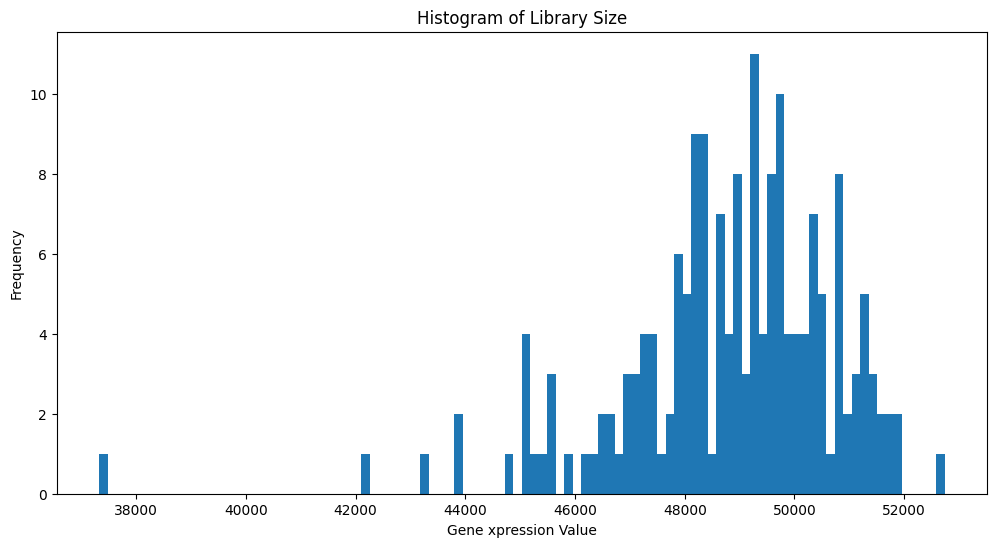

In [20]:
library_size=filter_log_CPM_df.sum(axis=0)# total sum of counts across all genes for each cell
fig, ax = plt.subplots(figsize=(12, 6))
plt.hist(library_size,bins=100) 
plt.title ('Histogram of Library Size')
plt.xlabel('Gene xpression Value')
plt.ylabel('Frequency') # Number of Samples
plt.show()

### Densities Plot of genes in Lesional and Normal Cells

 density plot of RNA-seq data is a useful tool for visualizing and analyzing gene expression levels in a sample or group of samples.

 **Steps**
 1. Make separate dataframe to normal and lesional data, using the log(CMP) data frame
 2. Calculate the mean of gene expration in each sampe(cell).
 3. Plot the value. 

In [21]:
# prepare 2 data frames, each data frame belons to a different cell type
# normal cells
gene_expration_normal=filter_log_CPM_df_T.loc[filter_log_CPM_df_T['type']=='normal',:]
gene_expration_normal=gene_expration_normal.drop(['type'],axis=1)

# lesional cells 
gene_expration_lesional=filter_log_CPM_df_T.loc[filter_log_CPM_df_T['type']=='lesional',:]
gene_expration_lesional=gene_expration_lesional.drop(['type'],axis=1)




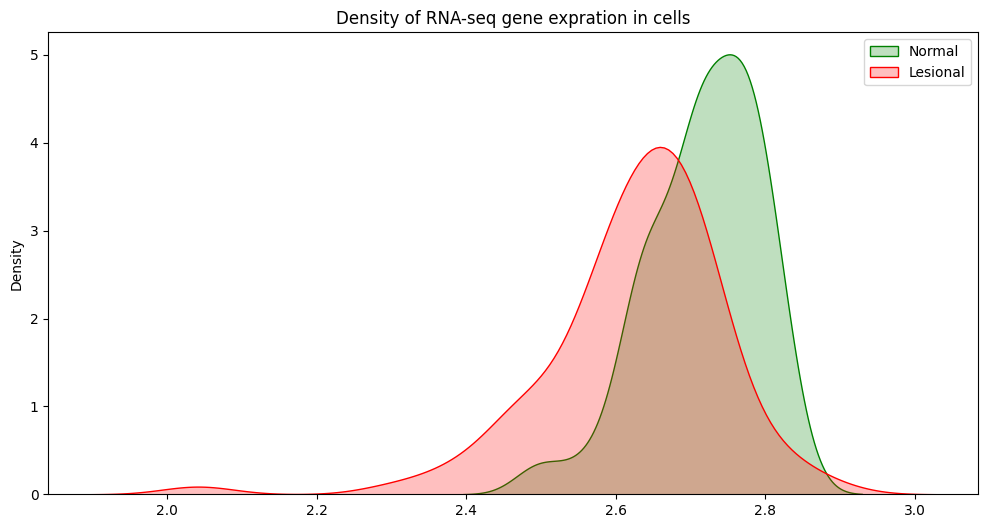

In [22]:
# plot the gene expression levels for each gene 
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(gene_expration_normal.T.mean(),ax=ax,fill=True,color='Green') # the normal cells gene expresion
sns.kdeplot(gene_expration_lesional.T.mean(),ax=ax,fill=True,color='red') # the lesional cells gene expresion
plt.legend (['Normal','Lesional'])
plt.title('Density of RNA-seq gene expration in cells')
plt.show()

### Plotting explained variance 

Often, you might be interested in seeing how much variance PCA is able to explain as you increase the number of components, in order to decide how many dimensions to ultimately keep or analyze. This example shows you how to quickly plot the cumulative sum of explained variance for a high-dimensional dataset like

With a higher explained variance, you are able to capture more variability in your dataset, which could potentially lead to better performance when training your model.

#### PCA

- PCA finds directions of maximal variance.
- Each PC represents a "metagene", which is a linear combination of information cross correlated sets of genes.
- PCs cannot capture nonlinear correlations beween genes.





#### PCA - 2 PC

In [29]:
def plot_pca(components,pca,title_n,color_by):
    '''
    This function makes scatter plot 
    
    Input:
    =======
    components - no.array -> the PC values
    pca - the model
    title_n- thitle of the plot
    color_by- hoe to color the scatter plot
    
    Output:
    =======
    
    '''
    labels = {
    str(i): f"PC {i+1} ({var:.1f}%)" 
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }
    fig = px.scatter_matrix(components, labels=labels, dimensions=range(2),color=color_by , title= title_n,height=800, width=800)
    fig.update_layout(legend_title_text='Cell Type')
    fig.show()
    

#### Scatter matrix plot with principal components with the  StandardScaler

In [24]:
#Principal components- 2 principal components 
cmp2=2
# Our data has different scales, so we need to standard it (this will affect the variance)
# StandardScaler- this step  ensures that all features are on the same scales and have similar ranges.  
filter_log_CPM_df_T_wo_type=filter_log_CPM_df_T.drop(['type'],axis=1) # remove the binary_type column
standard = StandardScaler()
scaled_data = standard.fit_transform(filter_log_CPM_df_T_wo_type)
pca2 = PCA(n_components=cmp2)
components_scaled = pca2.fit_transform(scaled_data)
plot_pca(components_scaled,pca2,'PCA of normalize  data by CMP with StandardScaler',filter_log_CPM_df_T['type'])


One attribute of the PCA class is the **explained_variance_ratio_** which, as the name suggests, tells us how much of the total variance is explained by each principal component.




In [25]:
pca2.explained_variance_ratio_

array([0.28058095, 0.22214142])

50% of the variance in the original dataset is explained by 2 principal componentsx

#### Scater matrix plot with principal components without the stantartization

In [26]:
#Principal components- 2 principal components  without StandardScaler

components_ns = pca2.fit_transform(filter_log_CPM_df_T_wo_type) # pca without stardared on  the data. 


In [27]:
pca2.explained_variance_ratio_

array([0.40457892, 0.12324827])

52% of the variance in the original dataset is explained by 2 principal componentsx
the variance is higher

In [28]:
plot_pca(components_ns,pca2, 'PCA of without StandardScale data by CMP',filter_log_CPM_df_T['type'])


**Note**

We can continue with the normalize data.

#### PCA - 3 PC

In [29]:
# Aapply PCA on the data, the n_components is 3 in this time 
cmp3=3
pca3 = PCA(n_components=cmp3)
components3 = pca3.fit_transform(scaled_data)

In case of 3 crincipal components, we can provide 3D scatter plot  

In [30]:
var = pca3.explained_variance_ratio_.sum()
fig = px.scatter_3d(components3, x=0, y=1, z=2, color=filter_log_CPM_df_T['type'],title=f'Total Explained Variance: {var}',
                    labels={'0':'PC1', '1':'PC2', '2':'PC3'})
fig.update_layout(legend_title_text='Cell type')
fig.show()

The total explained variance with two principal components was 52%. It has ingreaed by 5% when third principal component is added.


#### Compare transcriptomic profiles of two cells type 


Compare expression profiles between cell types, and your data is counts of genes expressed per cell. Your issue is that the data is highly dimensional. It has as many dimensions as you have genes. To be able find useful information, you must reduce these dimensions using a statistical technique such as Principal COmponents Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE).
Here is a a tSNE of my data. I have added the timepoint labels, but you can see that after performing the dimensionality reduction the two different timepoints cluster by their gene expression profiles. I can then use Seurat to see which specific genes are differentially expressed between the clusters and a whole bunch of other fun things.

In [31]:
# perform PCA to all components 
pca_scores = PCA().fit_transform(scaled_data)
# create a dataframe of pca_scores
df_pc = pd.DataFrame(pca_scores)
df_pc

0           1          2          3          4           5     
0    -45.093990  -69.137355 -23.183108  -2.565145 -15.592474   17.760753  \
1    161.373559  -29.881133 -14.849765  17.964402   1.750894   34.291966   
2    341.802276 -180.401719  16.407343  18.555509  89.756545  108.111675   
3     38.726609  -13.573924 -58.255097 -13.783427  -6.383660    3.552359   
4     68.387611   -0.160964  24.256324 -25.598828 -41.541159  -19.595108   
..          ...         ...        ...        ...        ...         ...   
173   32.710989 -114.793234   2.553573  23.590120  51.567276   -9.465806   
174  -54.327783  -33.008569  10.015355  31.361116  17.437770   -7.246182   
175   90.866785   -0.353160   2.660748 -38.740561 -11.121511    4.274386   
176  125.294350   30.124142  14.603575 -29.657637  15.340548  -21.602088   
177   29.243945   60.530483  22.600313 -39.133841 -20.975377    0.386906   

           6          7          8          9    ...       168       169   
0   -16.188170   9.932443  -2.178303  -5.627823  ...  0.632578 -1.268134  \
1   -17.717081  10.353229  -1.773295   4.036160  ... -0.034709  0.102262   
2   -55.535267   1.465747  52.816490   3.255511  ... -0.009028  0.237957   
3    -2.297370 -12.848917 -31.176406 -12.456468  ...  1.571006 -0.600361   
4   -13.409513 -20.024306  -1.428917 -25.603552  ... -0.896153  0.297487   
..         ...        ...        ...        ...  ...       ...       ...   
173   2.437847 -26.107674   0.734825 -11.977103  ...  0.912700  2.554826   
174   6.489257 -38.688248 -10.020806   4.480436  ...  6.634262  0.744956   
175   2.444477 -28.622062   4.790499  12.783697  ... -1.287308 -0.513934   
176  -8.685204   7.199722  11.547924 -31.640051  ... -1.042553 -1.244873   
177 -14.651011 -16.985004 -10.198909   5.275807  ...  3.939333 -1.457035   

          170       171       172       173       174       175       176   
0    0.510817 -0.695870 -3.090723  0.907031  2.101819  0.670795  1.271193  \
1    0.067466  0.465851 -0.216526  0.176736 -0.083051 -0.116210 -0.107584   
2   -0.087534  0.232561  0.059513 -0.039198  0.160278  0.090208  0.443902   
3   -2.143381  0.586652  3.360402  0.634938 -3.711322 -3.848024  0.538963   
4   -0.199774  0.231834 -1.422049 -0.143398  1.758260  0.410963  0.192346   
..        ...       ...       ...       ...       ...       ...       ...   
173 -0.591588 -1.033895  4.199601  0.039871 -0.848055  0.260627 -0.662120   
174  0.157392  1.929435 -3.030427 -0.514928  0.249591  0.213614  0.888235   
175  0.714336 -0.572655 -1.443759  1.166959  1.704813  2.231610  0.302056   
176 -0.483386  0.188061  1.105340 -1.056859  1.715325  0.445996 -0.535071   
177 -2.427482 -3.901884  2.749541  0.320402 -0.655596  2.549139  1.180755   

              177  
0    1.265255e-14  
1    1.265255e-14  
2    1.265255e-14  
3    1.265255e-14  
4    1.265255e-14  
..            ...  
173  1.265255e-14  
174  1.265255e-14  
175  1.265255e-14  
176  1.265255e-14  
177  1.265255e-14  

[178 rows x 178 columns]

Now, perform the t-SNE on the first 50 features obtained from the PCA. By default, TSNE() function uses the Barnes-Hut approximation, which is computationally less intensive.

In [32]:
# perform t-SNE on PCs scores
# we will use first 50 PCs but this can vary
from sklearn.manifold import TSNE
tsne_em = TSNE(n_components = 2, perplexity = 30.0, early_exaggeration = 12, 
               n_iter = 1000, learning_rate = 368, verbose = 1).fit_transform(df_pc.loc[:,0:49])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.077s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 54.086472
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.818863
[t-SNE] KL divergence after 1000 iterations: 0.345540


**Visualize the t-SNE clusters**

In [33]:
# plot t-SNE clusters
from bioinfokit.visuz import cluster
cluster.tsneplot(score=tsne_em)

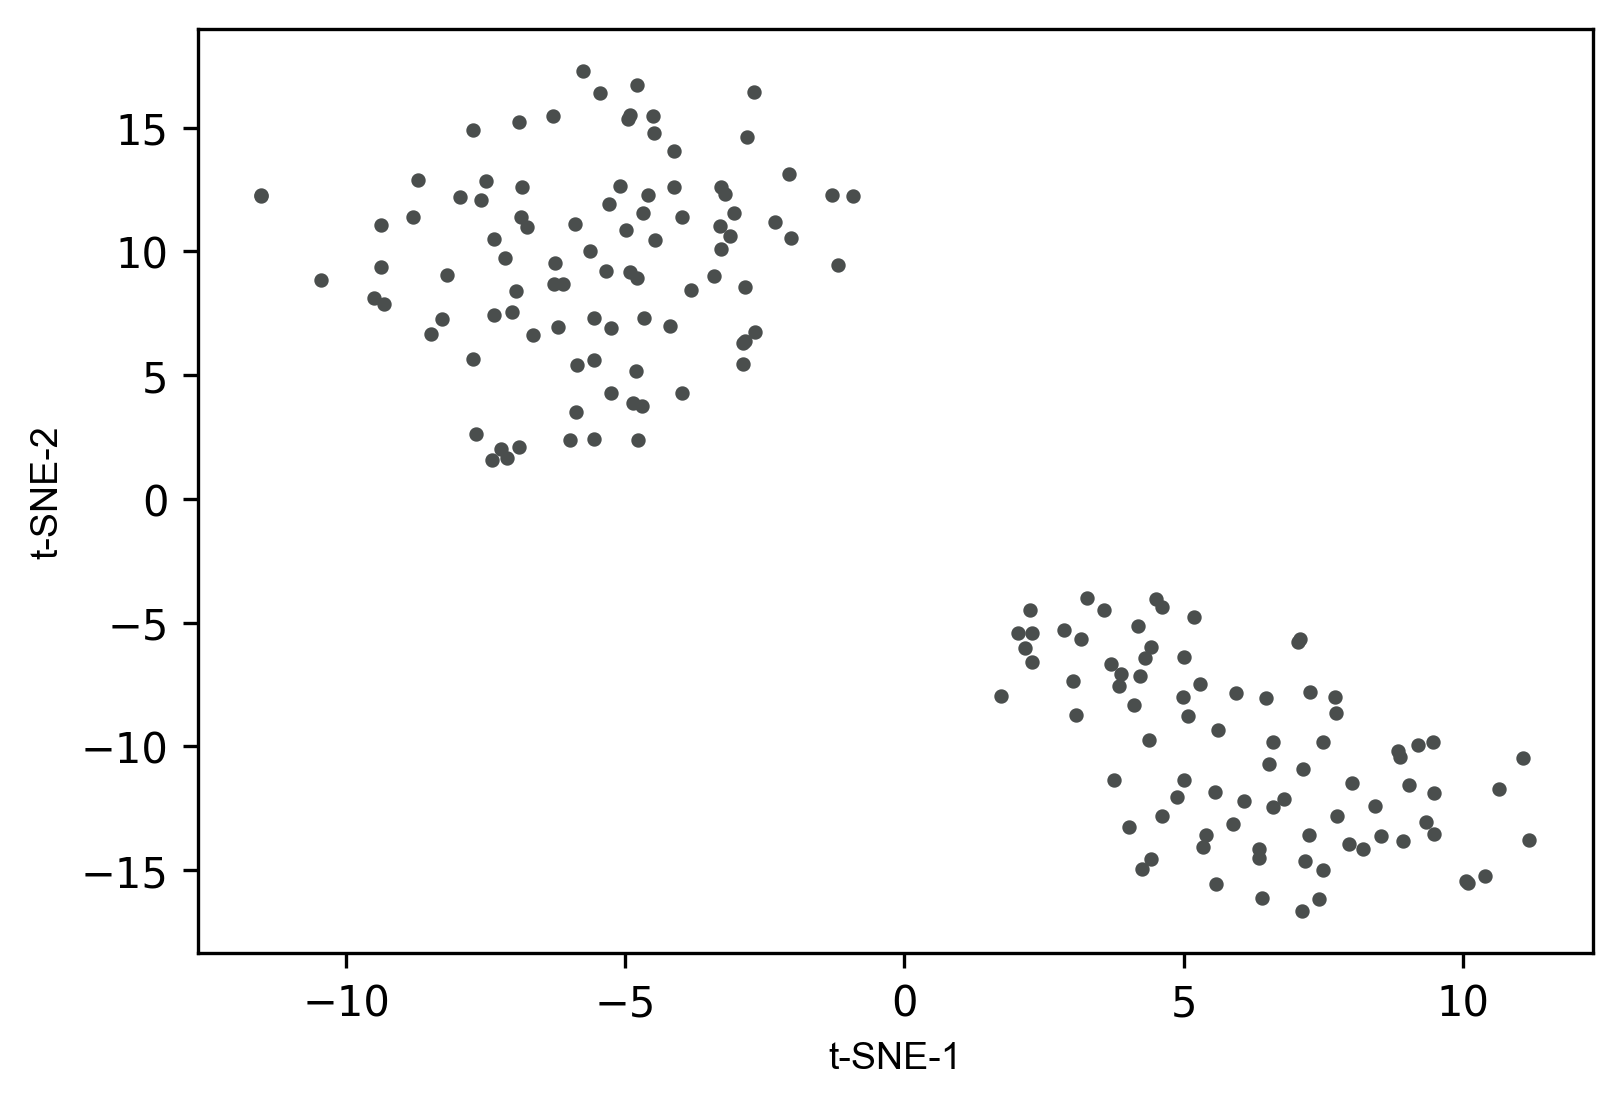

In [34]:
#from IPython import display
display.Image("/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/tsne_2d.png")

As t-SNE is an unsupervised learning method, we do not have sample target information. 

Hence, I will recognize the clusters using the DBSCAN clustering algorithm. 

This will help to color and visualize clusters of similar data points

In [35]:
#from IPython import display
from sklearn.cluster import DBSCAN


In [36]:
#from sklearn.cluster import DBSCAN
# here eps parameter is very important and optimizing eps is essential
# for well defined clusters. I have run DBSCAN with several eps values
# and got good clusters with eps=2
get_clusters = DBSCAN(eps = 2, min_samples = 10).fit_predict(tsne_em)
# check unique clusters
# -1 value represents noisy points could not assigned to any cluster
set(get_clusters)

{-1, 0, 1, 2}

**Generated t-SNE plot**

In [37]:
# get t-SNE plot with colors assigned to each cluster
cluster.tsneplot(score=tsne_em, colorlist=get_clusters, 
    colordot=('#713e5a', '#92AFD7', '#edc79b', '#d57a66'),#, '#ca6680', '#395B50', '#92AFD7', '#b0413e', '#4381c1', '#736ced', '#631a86', '#de541e', '#022b3a', '#000000'), 
    legendpos='upper right', legendanchor=(1.15, 1))


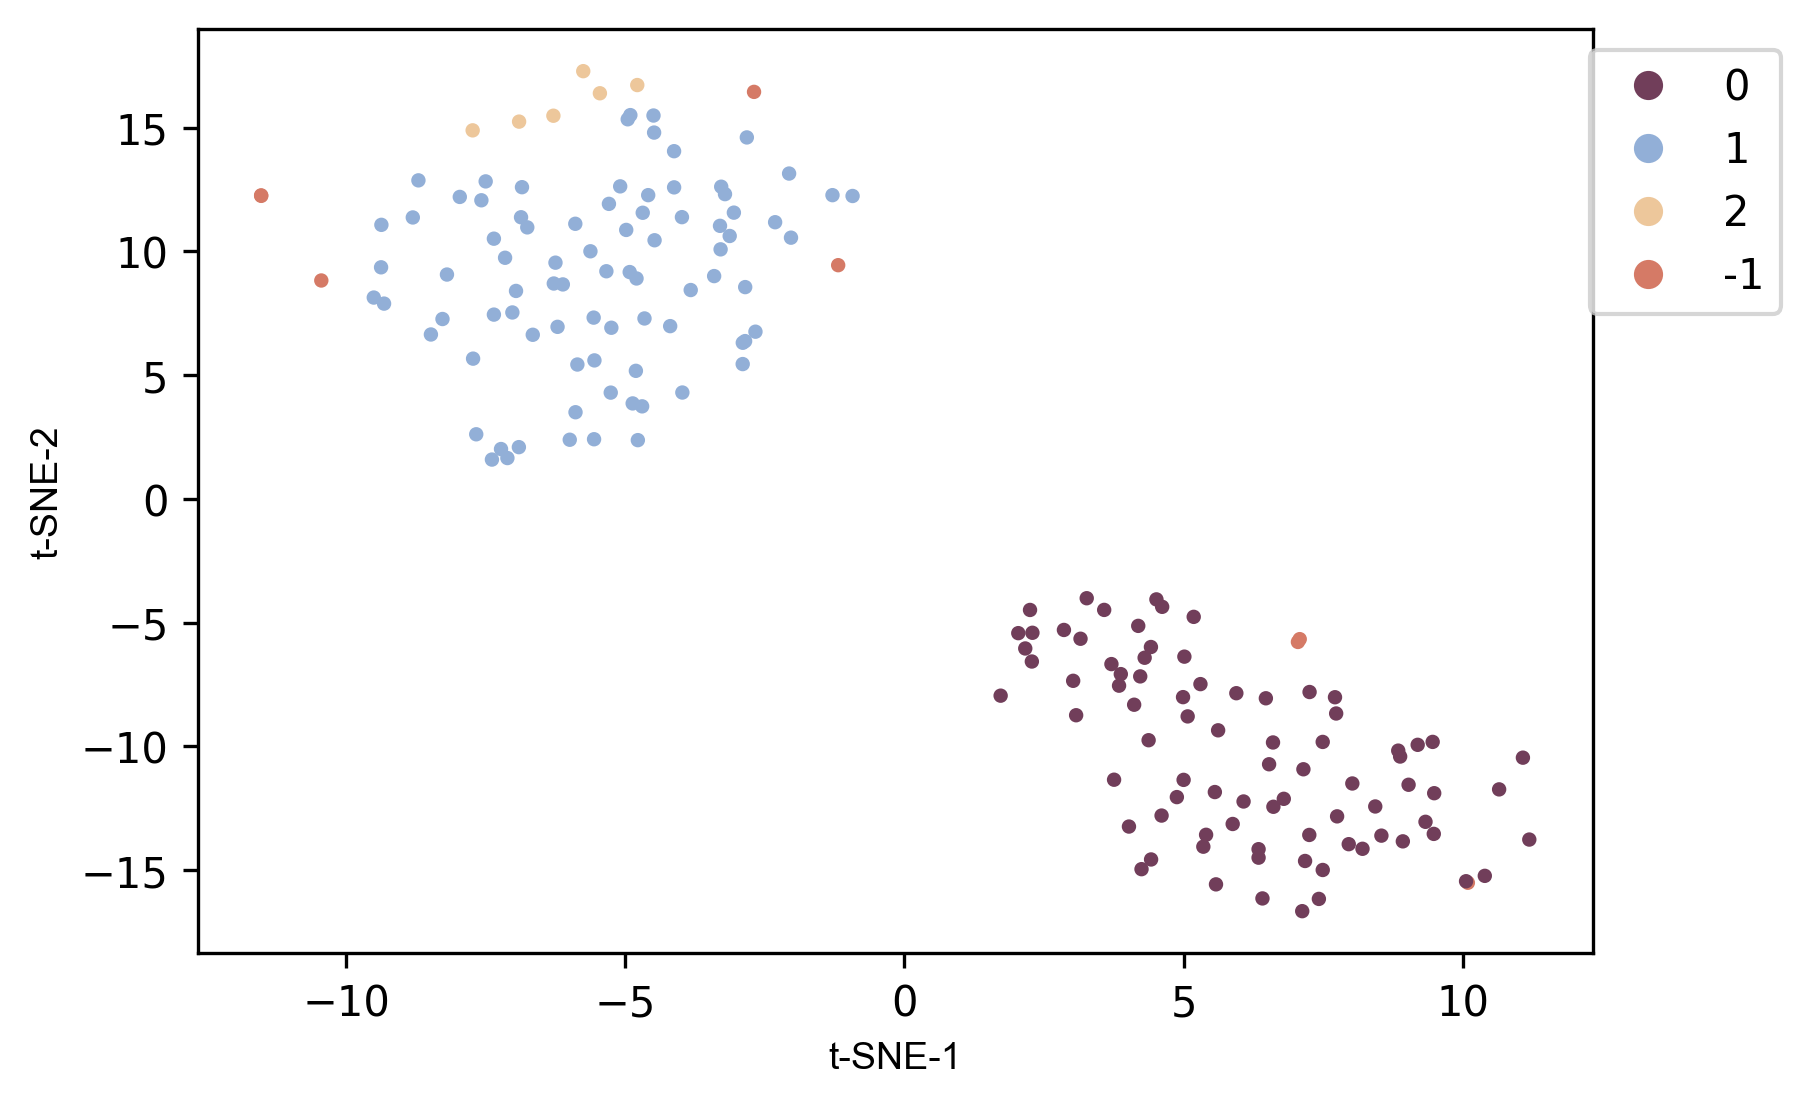

In [38]:
display.Image("/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/tsne_2d.png")

**Note**

1 and 0 represent the clusters points. Other values represent the noise point which could not be assigned to any cluster

**Conclution**

In t-SNE scatter plot, the points within the individual clusters are highly similar to each other and in distant to points in other clusters. 

The same pattern likely holds in a high-dimensional original dataset. In the context of scRNA-seq, these clusters represent the cells types with similar transcriptional profiles.

We have 2 cell type and we have 2 clusters big 

### 6. The PCA plot may suggest the presence of outlier/mislabeled samples in this dataset. 

Try to identify them and remove them from the downstream analysis.


In [28]:
# Import library
from pca import pca
def find_outliers(filter_log_CPM_df_T,label_col_name):
    
    '''
    #find the outliers and remove them
     # ht2 - Hotelling T2 -  It works by computing the chi-square tests across the top n_component pc1-pc5
    #The reason for not using more PC’s is that it is expected that the highest variance (and thus the outliers) 
    # will be seen in the first few components. Going deeper into PC space may therefore not be required. 
    # Nevertheless, the depth is optional.
    #The hotellings T2 test outputs a P-value matrix (samples x PCs), which are are subsequently combined using fishers method. 
    # This allows to determine outliers with its ranking (strongest to weak). The alpha parameter determines the detection of 
    # outliers (default: 0.05).

    # spe- SPE/Dmodx- (distance to model) based on the mean and covariance of the first 2 dimensions of X. On the model plane (SPE ≈ 0). 
    # Note that the SPE or Hotelling’s T2 are complementary to each other.
    '''

    filter_log_CPM_df_T_wo_type=filter_log_CPM_df_T.drop([label_col_name],axis=1) # remove the binary_type column
    
    # Initialize pca to also detected outliers.
    model = pca(normalize=True, detect_outliers=['ht2' ,'spe'], n_std=2 )  
    # Fit and transform
    results = model.fit_transform(filter_log_CPM_df_T_wo_type) # the data of pca after standartization 

    # Print outliers
    print(results['outliers'])
    return results


In [40]:
#Principal components- 2 principal components of data withut outliers 

# Our data has different scales, so we need to standard it (this will effect the variance)
# StandardScaler- this step ensures that all features are on the same scales and have similar ranges. 
# Xnormal = filter_log_CPM_df_T_wo_type.loc[~results['outliers']['y_bool'],:] # remove the 

results=find_outliers(filter_log_CPM_df_T,'type')
Xnormal=filter_log_CPM_df_T.loc[~results['outliers']['y_bool_spe']].drop(['type'],axis=1) # remove the binary_type column
standard = StandardScaler()
scaled_data = standard.fit_transform(Xnormal)
pca2_scaled = PCA(n_components=cmp2)
components = pca2_scaled.fit_transform(scaled_data)
plot_pca(components,pca2_scaled,'PCA of normalize data by log-CMP with StandardScaler - remove the outliers',filter_log_CPM_df_T.loc[~results['outliers']['y_bool_spe'],'type'])


[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [18286] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [93] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [18286] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[93]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
                  y_proba          p_raw      y_score  y_bool  y_bool_spe   
SRR1146076   1.000000e+00   9.999154e-01   122.048499   False       False  \
SRR1146077  1.889907e-201  2.017317e-202  1491.820477    True        True   
SRR1146078   0.0

We removed all ouliers. The red cell in the blue is a mis-labled cell.

In [41]:
Outliers_number=filter_log_CPM_df_T.shape[0]-Xnormal.shape[0] 
print (f"They are {Outliers_number} in the data and we remove them")
       

They are 14 in the data and we remove them


### The Mis-labeled Cell find and remove 

I will saperate the data into 2 groups - normal and lesion cells, and remove the outliers in each group seperetly. Then I will remove all cells from the data frame with all cells and plot the cpa again




In [42]:
def find_the_outliers(X,y,cmp):
    '''
    This function calculates the PCA, then applies the LOF to the reduced data
    Use fit_predict() to compute the predicted labels of the training samples. 
    When LOF is used for outlier detection, the estimator has no predict(), 
    decision_function() and score_samples() methods.
    LOF score(x_scores) tells us if a data point has a substantially 
    lower density than its neighbors, then the data point is considered as an outlier.
    Input:
    ======
    X : DataFrame  all data without the type
    y: list of list of cell type
    
    Output:
    =======
    lofs_index: tuple of list of normal cells and not outliers
    '''
    
    #Reducing the dimension using Principal Component Analysis(PCA) for visualization
    pca = PCA(n_components=cmp)
    pca.fit(X)
    X_pca = pca.transform(X)
    # fit the model for outlier detection 
    clf = LocalOutlierFactor(n_neighbors=25, contamination=0.1)#the default value of 25 nearest neighbors to measure the local deviation of the density.
    # use fit_predict to compute the predicted labels of the training samples

    y_pred = clf.fit_predict(X_pca)
    n_errors = (y_pred != y).sum()


    X_scores = clf.negative_outlier_factor_
    
    
    # y_pred is 1 for a not outlier and -1 is for an outlier.
    # Visualize the outliers using matplotlib, where the LOF score is  1 not outliers .
    lofs_index = np.where(y_pred==1) # the not outliers
    values = X_pca[lofs_index]
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(X_pca[:,0], X_pca[:,1], label="Outliers")
    plt.scatter(values[:,0],values[:,1], color='r', label='Normal')
    plt.legend(loc='lower right')
    plt.show()
    return lofs_index

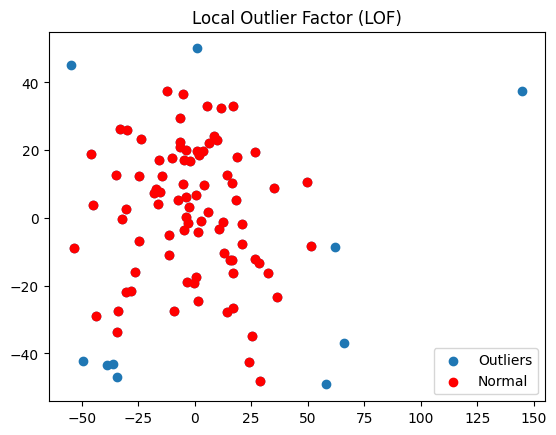

In [43]:
# remove the outliers from the dataframe 
X=gene_expration_lesional
y=[[1]]*X.shape[1]
wo_outliers_lesional_cells=find_the_outliers(X,y,cmp2)

In [44]:
# remove the outliers cells 
gene_expration_lesional_wo_outliesrs=gene_expration_lesional.reset_index().iloc[wo_outliers_lesional_cells[0]]
gene_expration_lesional_wo_outliesrs=gene_expration_lesional_wo_outliesrs.set_index('index') # make the index again 
gene_expration_lesional_wo_outliesrs.index.names=[None] # remove the name 
gene_expration_lesional_wo_outliesrs

ENSG00000106290  ENSG00000163093  ENSG00000111052   
SRR1146077         3.610631         1.082197        -0.430379  \
SRR1146079         3.535718         1.735100         0.432580   
SRR1146080         3.591037         1.398845        -0.509072   
SRR1146081         3.764089         1.629546        -0.157290   
SRR1146082         2.772359         2.156599         0.924892   
...                     ...              ...              ...   
SRR1146241         3.834972         1.667864         0.383044   
SRR1146242         3.593163         1.843965         0.084474   
SRR1146252         3.426273         1.633703         0.336050   
SRR1146253         3.452179         1.216211        -0.223318   
SRR1146254         3.290330         1.148371         0.219914   

            ENSG00000168917  ENSG00000130311  ENSG00000125945   
SRR1146077         0.405860         3.570626         2.901811  \
SRR1146079         0.873134         3.356119         3.612115   
SRR1146080         1.289894         3.291760         3.399450   
SRR1146081         0.891053         3.499450         2.888621   
SRR1146082         1.653846         3.078345         3.489838   
...                     ...              ...              ...   
SRR1146241         0.365344         3.622059         3.209000   
SRR1146242         0.609480         3.339810         3.511515   
SRR1146252         0.843295         3.398265         3.157635   
SRR1146253         0.559435         3.360189         2.999289   
SRR1146254         1.132110         3.183495         3.409795   

            ENSG00000197859  ENSG00000165181  ENSG00000160961   
SRR1146077         0.946242         0.485903         1.553258  \
SRR1146079         0.939825         0.213892         2.304377   
SRR1146080         0.362757        -1.246653         2.123739   
SRR1146081         1.052540         0.859637         2.224422   
SRR1146082        -0.272151         1.042674         2.221327   
...                     ...              ...              ...   
SRR1146241         0.310285         1.245263         1.791026   
SRR1146242         0.354135         1.056328         2.273722   
SRR1146252         0.717415        -0.223561         1.909114   
SRR1146253         0.765286         0.680386         1.761974   
SRR1146254         0.438966        -0.008342         2.086989   

            ENSG00000146707  ...  ENSG00000129116  ENSG00000162493   
SRR1146077         2.332534  ...         4.747492         2.851096  \
SRR1146079         1.583374  ...         5.115531         3.242407   
SRR1146080         1.908378  ...         5.101497         3.078047   
SRR1146081         2.496355  ...         4.541305         3.174903   
SRR1146082         1.643745  ...         5.442706         3.401076   
...                     ...  ...              ...              ...   
SRR1146241         1.433738  ...         4.916202         3.174095   
SRR1146242         2.405919  ...         4.901284         3.236386   
SRR1146252         1.744415  ...         4.989323         3.374595   
SRR1146253         2.533511  ...         4.817672         3.118869   
SRR1146254         2.815771  ...         5.257654         3.215639   

            ENSG00000197044  ENSG00000063245  ENSG00000183476   
SRR1146077         0.574195         5.131175         1.021043  \
SRR1146079         1.397657         4.877533         0.907036   
SRR1146080         1.082808         5.078811        -0.089224   
SRR1146081         0.723062         5.069077         1.069931   
SRR1146082         2.442759         4.378507         0.767264   
...                     ...              ...              ...   
SRR1146241         1.323595         4.847330         0.383044   
SRR1146242         1.749474         4.857769         0.298046   
SRR1146252         1.089818         5.048465         0.388235   
SRR1146253         0.485327         5.134582         0.705388   
SRR1146254         1.553835         4.724015         0.317077   

            ENSG00000100162  ENSG00000073169  E

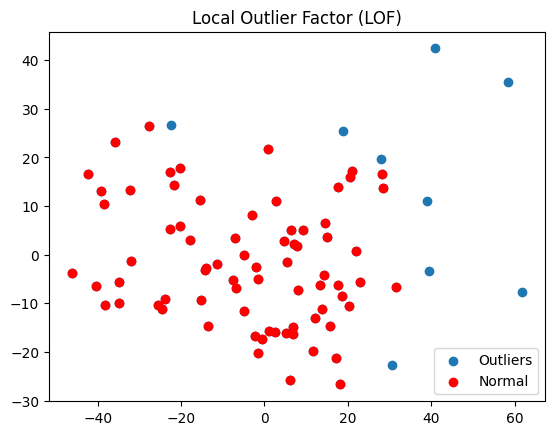

In [45]:
# remove outliers from normal cells 
X=gene_expration_normal
y=[[0]]*X.shape[1]
wo_outliers_normal_cells=find_the_outliers(X,y,cmp2)

In [46]:
# # remove the outliers cells 
gene_expration_normal_wo_outliesrs=gene_expration_normal.reset_index().iloc[wo_outliers_normal_cells[0]]
gene_expration_normal_wo_outliesrs=gene_expration_normal_wo_outliesrs.set_index('index') # make the index again 
gene_expration_normal_wo_outliesrs.index.names=[None] # remove the name 
gene_expration_normal_wo_outliesrs

ENSG00000106290  ENSG00000163093  ENSG00000111052   
SRR1146076         3.793098         1.726179         0.576516  \
SRR1146086         3.141723         1.892985         0.939883   
SRR1146088         3.985896         2.022287         0.566039   
SRR1146096         3.277323         1.914019         0.542767   
SRR1146101         3.606735         1.443825         0.863158   
...                     ...              ...              ...   
SRR1146244         3.649266         1.857507         0.089853   
SRR1146245         3.741379         1.719772         0.812617   
SRR1146246         3.803995         1.707094         0.163621   
SRR1146247         3.631741         1.465534         0.482758   
SRR1146250         3.457368         1.862021         0.750990   

            ENSG00000168917  ENSG00000130311  ENSG00000125945   
SRR1146076         1.140203         3.348206         3.614892  \
SRR1146086         1.438128         2.926612         3.852003   
SRR1146088         0.966659         3.431129         3.462826   
SRR1146096         1.133862         3.236783         3.964639   
SRR1146101         0.830722         3.241517         3.722920   
...                     ...              ...              ...   
SRR1146244         0.851988         3.534527         3.742973   
SRR1146245         0.625740         3.438598         3.370544   
SRR1146246         0.732310         3.567643         3.326481   
SRR1146247         0.331209         3.399678         3.787805   
SRR1146250         1.105160         3.392718         3.888651   

            ENSG00000197859  ENSG00000165181  ENSG00000160961   
SRR1146076         0.892367        -2.062468         2.659518  \
SRR1146086         0.089112        -0.851857         3.033542   
SRR1146088         0.649420        -1.270142         2.722168   
SRR1146096        -0.196183        -0.953855         2.548669   
SRR1146101         0.568359        -1.115162         2.336017   
...                     ...              ...              ...   
SRR1146244         0.223383        -1.568336         2.117367   
SRR1146245         0.899628        -0.720265         2.306538   
SRR1146246         0.995600        -1.047449         2.232360   
SRR1146247         0.418219        -0.731672         1.962224   
SRR1146250         0.106637        -1.839219         2.569468   

            ENSG00000146707  ...  ENSG00000129116  ENSG00000162493   
SRR1146076         2.121030  ...         5.294754         2.949421  \
SRR1146086         2.642732  ...         5.522186         3.060143   
SRR1146088         2.843673  ...         4.973812         3.168186   
SRR1146096         2.248866  ...         5.290027         3.071471   
SRR1146101         3.103184  ...         5.354416         2.839006   
...                     ...  ...              ...              ...   
SRR1146244         2.360988  ...         4.985905         2.866888   
SRR1146245         2.963317  ...         5.319719         2.849989   
SRR1146246         2.127597  ...         4.979595         3.298182   
SRR1146247         1.423737  ...         5.190168         2.951910   
SRR1146250         1.450365  ...         4.850732         2.534377   

            ENSG00000197044  ENSG00000063245  ENSG00000183476   
SRR1146076         1.796077         4.608473        -0.034389  \
SRR1146086         2.491424         3.765713         0.113209   
SRR1146088         2.333342         4.877319         0.594612   
SRR1146096         2.344423         4.172461         0.542767   
SRR1146101         1.804657         4.601329         0.524557   
...                     ...              ...              ...   
SRR1146244         1.708762         4.904155         0.264205   
SRR1146245         1.755812         4.800122         0.509669   
SRR1146246         1.350420         4.836243         0.205293   
SRR1146247         1.607074         4.589004         0.294168   
SRR1146250         1.971079         4.555980        -0.372930   

            ENSG00000100162  ENSG00000073169  E

In [47]:
# add type column to matrix 
gene_expration_normal_wo_outliesrs['type']='normal'
gene_expration_lesional_wo_outliesrs['type']='lision'


In [48]:
# concat to one dataframe 
data_wo_outliers= [gene_expration_normal_wo_outliesrs,gene_expration_lesional_wo_outliesrs]
data_wo_outliers_df=pd.concat(data_wo_outliers,axis=0)
data_wo_outliers_df.head()

ENSG00000106290  ENSG00000163093  ENSG00000111052   
SRR1146076         3.793098         1.726179         0.576516  \
SRR1146086         3.141723         1.892985         0.939883   
SRR1146088         3.985896         2.022287         0.566039   
SRR1146096         3.277323         1.914019         0.542767   
SRR1146101         3.606735         1.443825         0.863158   

            ENSG00000168917  ENSG00000130311  ENSG00000125945   
SRR1146076         1.140203         3.348206         3.614892  \
SRR1146086         1.438128         2.926612         3.852003   
SRR1146088         0.966659         3.431129         3.462826   
SRR1146096         1.133862         3.236783         3.964639   
SRR1146101         0.830722         3.241517         3.722920   

            ENSG00000197859  ENSG00000165181  ENSG00000160961   
SRR1146076         0.892367        -2.062468         2.659518  \
SRR1146086         0.089112        -0.851857         3.033542   
SRR1146088         0.649420        -1.270142         2.722168   
SRR1146096        -0.196183        -0.953855         2.548669   
SRR1146101         0.568359        -1.115162         2.336017   

            ENSG00000146707  ...  ENSG00000162493  ENSG00000197044   
SRR1146076         2.121030  ...         2.949421         1.796077  \
SRR1146086         2.642732  ...         3.060143         2.491424   
SRR1146088         2.843673  ...         3.168186         2.333342   
SRR1146096         2.248866  ...         3.071471         2.344423   
SRR1146101         3.103184  ...         2.839006         1.804657   

            ENSG00000063245  ENSG00000183476  ENSG00000100162   
SRR1146076         4.608473        -0.034389         0.710047  \
SRR1146086         3.765713         0.113209         0.064420   
SRR1146088         4.877319         0.594612         0.608598   
SRR1146096         4.172461         0.542767         0.465209   
SRR1146101         4.601329         0.524557         0.954591   

            ENSG00000073169  ENSG00000064012  ENSG00000179922   
SRR1146076         2.879096         2.691044         1.787602  \
SRR1146086         2.619699         2.698097         1.551683   
SRR1146088         3.041231         2.315864         1.774346   
SRR1146096         2.851299         2.932483         1.569179   
SRR1146101         2.301274         2.121978         1.107354   

            ENSG00000224086    type  
SRR1146076         3.351774  normal  
SRR1146086         3.073799  normal  
SRR1146088         3.453987  normal  
SRR1146096         2.966110  normal  
SRR1146101         3.000714  normal  

[5 rows x 18287 columns]

In [57]:
# calculate the PCA and plot again - cheking that we removed the outliers 
data_wo_outliers_df_wo_type=data_wo_outliers_df.drop(['type'],axis=1)
standard = StandardScaler()
scaled_data = standard.fit_transform(data_wo_outliers_df_wo_type)
pca2 = PCA(n_components=cmp2)
components = pca2.fit_transform(scaled_data)
plot_pca(components,pca2, 'PCA of normalize data by log-CMP with StandardScaler - remove the outliers ',data_wo_outliers_df['type'])


### 7. Differential expression analysis comparing mRNA abundance in lesional vs normal group samples. 

In [50]:
gene_expration_normal_wo_outliesrs.drop(['type'],axis=1)

ENSG00000106290  ENSG00000163093  ENSG00000111052   
SRR1146076         3.793098         1.726179         0.576516  \
SRR1146086         3.141723         1.892985         0.939883   
SRR1146088         3.985896         2.022287         0.566039   
SRR1146096         3.277323         1.914019         0.542767   
SRR1146101         3.606735         1.443825         0.863158   
...                     ...              ...              ...   
SRR1146244         3.649266         1.857507         0.089853   
SRR1146245         3.741379         1.719772         0.812617   
SRR1146246         3.803995         1.707094         0.163621   
SRR1146247         3.631741         1.465534         0.482758   
SRR1146250         3.457368         1.862021         0.750990   

            ENSG00000168917  ENSG00000130311  ENSG00000125945   
SRR1146076         1.140203         3.348206         3.614892  \
SRR1146086         1.438128         2.926612         3.852003   
SRR1146088         0.966659         3.431129         3.462826   
SRR1146096         1.133862         3.236783         3.964639   
SRR1146101         0.830722         3.241517         3.722920   
...                     ...              ...              ...   
SRR1146244         0.851988         3.534527         3.742973   
SRR1146245         0.625740         3.438598         3.370544   
SRR1146246         0.732310         3.567643         3.326481   
SRR1146247         0.331209         3.399678         3.787805   
SRR1146250         1.105160         3.392718         3.888651   

            ENSG00000197859  ENSG00000165181  ENSG00000160961   
SRR1146076         0.892367        -2.062468         2.659518  \
SRR1146086         0.089112        -0.851857         3.033542   
SRR1146088         0.649420        -1.270142         2.722168   
SRR1146096        -0.196183        -0.953855         2.548669   
SRR1146101         0.568359        -1.115162         2.336017   
...                     ...              ...              ...   
SRR1146244         0.223383        -1.568336         2.117367   
SRR1146245         0.899628        -0.720265         2.306538   
SRR1146246         0.995600        -1.047449         2.232360   
SRR1146247         0.418219        -0.731672         1.962224   
SRR1146250         0.106637        -1.839219         2.569468   

            ENSG00000146707  ...  ENSG00000129116  ENSG00000162493   
SRR1146076         2.121030  ...         5.294754         2.949421  \
SRR1146086         2.642732  ...         5.522186         3.060143   
SRR1146088         2.843673  ...         4.973812         3.168186   
SRR1146096         2.248866  ...         5.290027         3.071471   
SRR1146101         3.103184  ...         5.354416         2.839006   
...                     ...  ...              ...              ...   
SRR1146244         2.360988  ...         4.985905         2.866888   
SRR1146245         2.963317  ...         5.319719         2.849989   
SRR1146246         2.127597  ...         4.979595         3.298182   
SRR1146247         1.423737  ...         5.190168         2.951910   
SRR1146250         1.450365  ...         4.850732         2.534377   

            ENSG00000197044  ENSG00000063245  ENSG00000183476   
SRR1146076         1.796077         4.608473        -0.034389  \
SRR1146086         2.491424         3.765713         0.113209   
SRR1146088         2.333342         4.877319         0.594612   
SRR1146096         2.344423         4.172461         0.542767   
SRR1146101         1.804657         4.601329         0.524557   
...                     ...              ...              ...   
SRR1146244         1.708762         4.904155         0.264205   
SRR1146245         1.755812         4.800122         0.509669   
SRR1146246         1.350420         4.836243         0.205293   
SRR1146247         1.607074         4.589004         0.294168   
SRR1146250         1.971079         4.555980        -0.372930   

            ENSG00000100162  ENSG00000073169  E

In [51]:
gene_expration_normal_wo_outliesrs.drop(['type'],axis=1).mean(axis=1)

SRR1146076    2.754315
SRR1146086    2.754777
SRR1146088    2.788230
SRR1146096    2.795332
SRR1146101    2.639762
                ...   
SRR1146244    2.631610
SRR1146245    2.697337
SRR1146246    2.659907
SRR1146247    2.635141
SRR1146250    2.694046
Length: 74, dtype: float64

/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_39578/3334564199.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_39578/3334564199.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_39578/3

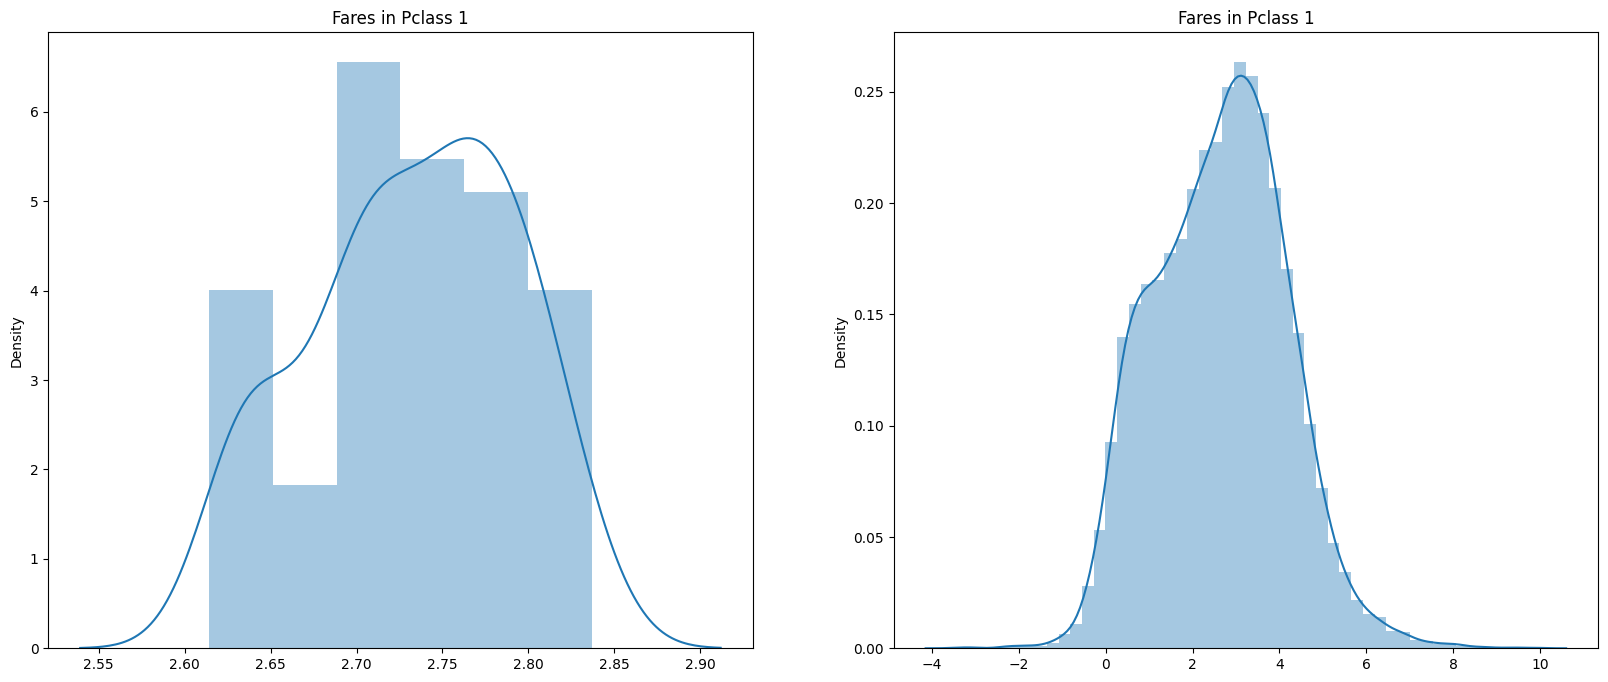

In [364]:
fig,ax=plt.subplots(1,2, figsize=(20,8))

sns.distplot((gene_expration_normal_wo_outliesrs.drop(['type'],axis=1).mean(axis=1)),ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot((gene_expration_lesional_wo_outliesrs.drop(['type'],axis=1).mean()),ax=ax[1])
ax[1].set_title('Fares in Pclass 1')
fig.show()

In [365]:
sns.heatmap(gene_expration_normal_wo_outliesrs.drop(['type'],axis=1).corr()) # take sto mach time ... we have too many features 

In [52]:
# Calculate Q1 and Q2
Q1=gene_expration_normal_wo_outliesrs.drop(['type'],axis=1).quantile(0.25)
Q2=gene_expration_normal_wo_outliesrs.drop(['type'],axis=1).quantile(0.75)

In [53]:
Q1

ENSG00000106290    3.455403
ENSG00000163093    1.711190
ENSG00000111052    0.567982
ENSG00000168917    0.834760
ENSG00000130311    3.217619
                     ...   
ENSG00000100162    0.358942
ENSG00000073169    2.455235
ENSG00000064012    2.210388
ENSG00000179922    1.420085
ENSG00000224086    2.929961
Name: 0.25, Length: 18286, dtype: float64

In [ ]:
# take too much time, we can undestand each feature destribution 
import plotly.express as px

fig = px.box(gene_expration_normal_wo_outliesrs)
fig.show()

### 8. Select the top 100 most significant annotated genes and generate a heatmap of the log-CPM data, with samples in columns, annotated with the group variable.

In [59]:
# find the 100 most significant genes
from pca import pca
component12_df=pd.DataFrame(pca2.components_.T, index=list(filter_log_CPM_df_T_wo_type.loc[~results['outliers']['y_bool_spe']].columns),columns=['pc1', 'pc2'])
sort_components_W_df=component12_df.sort_values(by=['pc1','pc2'],ascending=False) # sort the conents 
segnificant_genes=list(sort_components_W_df.iloc[:100,:].index) # slices the 100 most segnificant genes 


In [60]:
# slice from df only the significant genes 
most_100_segnificanty_logCMP_genes=filter_log_CPM_df_T_wo_type.loc[:,segnificant_genes].T

sort_df_by_cell_type=[most_100_segnificanty_logCMP_genes.loc[:,list(gene_expration_lesional.index)], most_100_segnificanty_logCMP_genes.loc[:,list(gene_expration_normal.index)]]
sort_dframe=pd.concat(sort_df_by_cell_type,axis=1)
sort_dframe

SRR1146077  SRR1146078  SRR1146079  SRR1146080  SRR1146081   
ENSG00000188643    6.433851    6.313565    5.872205    6.131185    6.240167  \
ENSG00000060558    5.298206    5.722338    4.743133    4.488417    5.006644   
ENSG00000159166    6.478476    6.570632    6.020892    6.197029    6.203797   
ENSG00000169230    4.938812    5.370130    4.561147    4.727585    4.861146   
ENSG00000175793    8.177174    8.703742    7.447901    7.399043    7.972619   
...                     ...         ...         ...         ...         ...   
ENSG00000275011    3.134796    3.399758    2.373370    1.975819    3.202870   
ENSG00000166851    3.310019    3.210380    3.312976    3.426991    3.229081   
ENSG00000167900    3.697361    4.114342    3.724435    3.611715    3.731513   
ENSG00000125780    7.102229    7.793480    5.505289    5.529819    6.693260   
ENSG00000241794    8.090002    7.664118    7.013188    6.729471    7.962097   

                 SRR1146082  SRR1146083  SRR1146084  SRR1146087  SRR1146089   
ENSG00000188643    5.851386    6.310347    5.702218    6.089083    5.967492  \
ENSG00000060558    4.322956    4.553299    4.212060    4.632224    4.612411   
ENSG00000159166    5.995886    6.293957    5.766657    6.064313    6.033743   
ENSG00000169230    4.470065    4.698373    4.279383    4.669505    4.245233   
ENSG00000175793    7.072220    7.678893    6.730848    7.901610    7.583995   
...                     ...         ...         ...         ...         ...   
ENSG00000275011    1.988162    2.165231    2.514330    2.991775    1.542413   
ENSG00000166851    2.369354    3.199821    2.819487    2.906275    2.670384   
ENSG00000167900    2.449585    3.631120    2.880575    3.306613    2.657645   
ENSG00000125780    6.164980    6.126818    6.293358    5.677817    5.849943   
ENSG00000241794    7.858148    7.432653    7.572642    7.347054    7.716848   

                 ...  SRR1146236  SRR1146238  SRR1146243  SRR1146244   
ENSG00000188643  ...    5.469975    5.453645    5.477540    5.621538  \
ENSG00000060558  ...    4.110774    3.704819    3.923101    4.145349   
ENSG00000159166  ...    5.616109    5.608559    5.728323    5.692841   
ENSG00000169230  ...    4.204368    4.301518    4.305545    4.236751   
ENSG00000175793  ...    7.041056    6.938662    7.024833    6.879754   
...              ...         ...         ...         ...         ...   
ENSG00000275011  ...    1.043354    0.182150    1.296022    0.977151   
ENSG00000166851  ...    1.855282    1.820331    1.634476    1.845237   
ENSG00000167900  ...    2.449713    2.448669    2.568430    2.408959   
ENSG00000125780  ...    4.642758    4.644452    4.478981    4.858509   
ENSG00000241794  ...    1.839153    1.740288    3.233962    2.801064   

                 SRR1146245  SRR1146246  SRR1146247  SRR1146248  SRR1146249   
ENSG00000188643    5.381331    5.502990    5.506015    5.576829    5.477008  \
ENSG00000060558    3.568731    3.941010    3.985396    4.247052    3.954176   
ENSG00000159166    5.605487    5.750224    5.583665    5.744251    5.724079   
ENSG00000169230    4.270505    4.281785    4.272254    4.321767    4.307312   
ENSG00000175793    6.810223    6.816887    6.705793    7.203973    7.105517   
...                     ...         ...         ...         ...         ...   
ENSG00000275011    1.195091    2.213363    1.175902    1.327065    1.021291   
ENSG00000166851    1.592773    1.969458    1.607074    1.981811    1.904304   
ENSG00000167900    2.533755    3.309231    2.550406    2.504664    2.574636   
ENSG00000125780    4.930170    4.994306    4.527446    4.956322    5.033567   
ENSG00000241794    1.799109    2.474673    3.005977    3.050318    3.006668   

                 SRR1146250  
ENSG00000188643    5.363751  
ENSG00000060558    3.774454  
ENSG00000159166    5.488718  
ENSG00000169230    3.985242  
ENSG00000175793    6.615504  
...                     ...  
ENSG00000275011    1.431556  
ENSG00000166851    1.785061  
ENSG00000167900    2.010867  
ENSG0

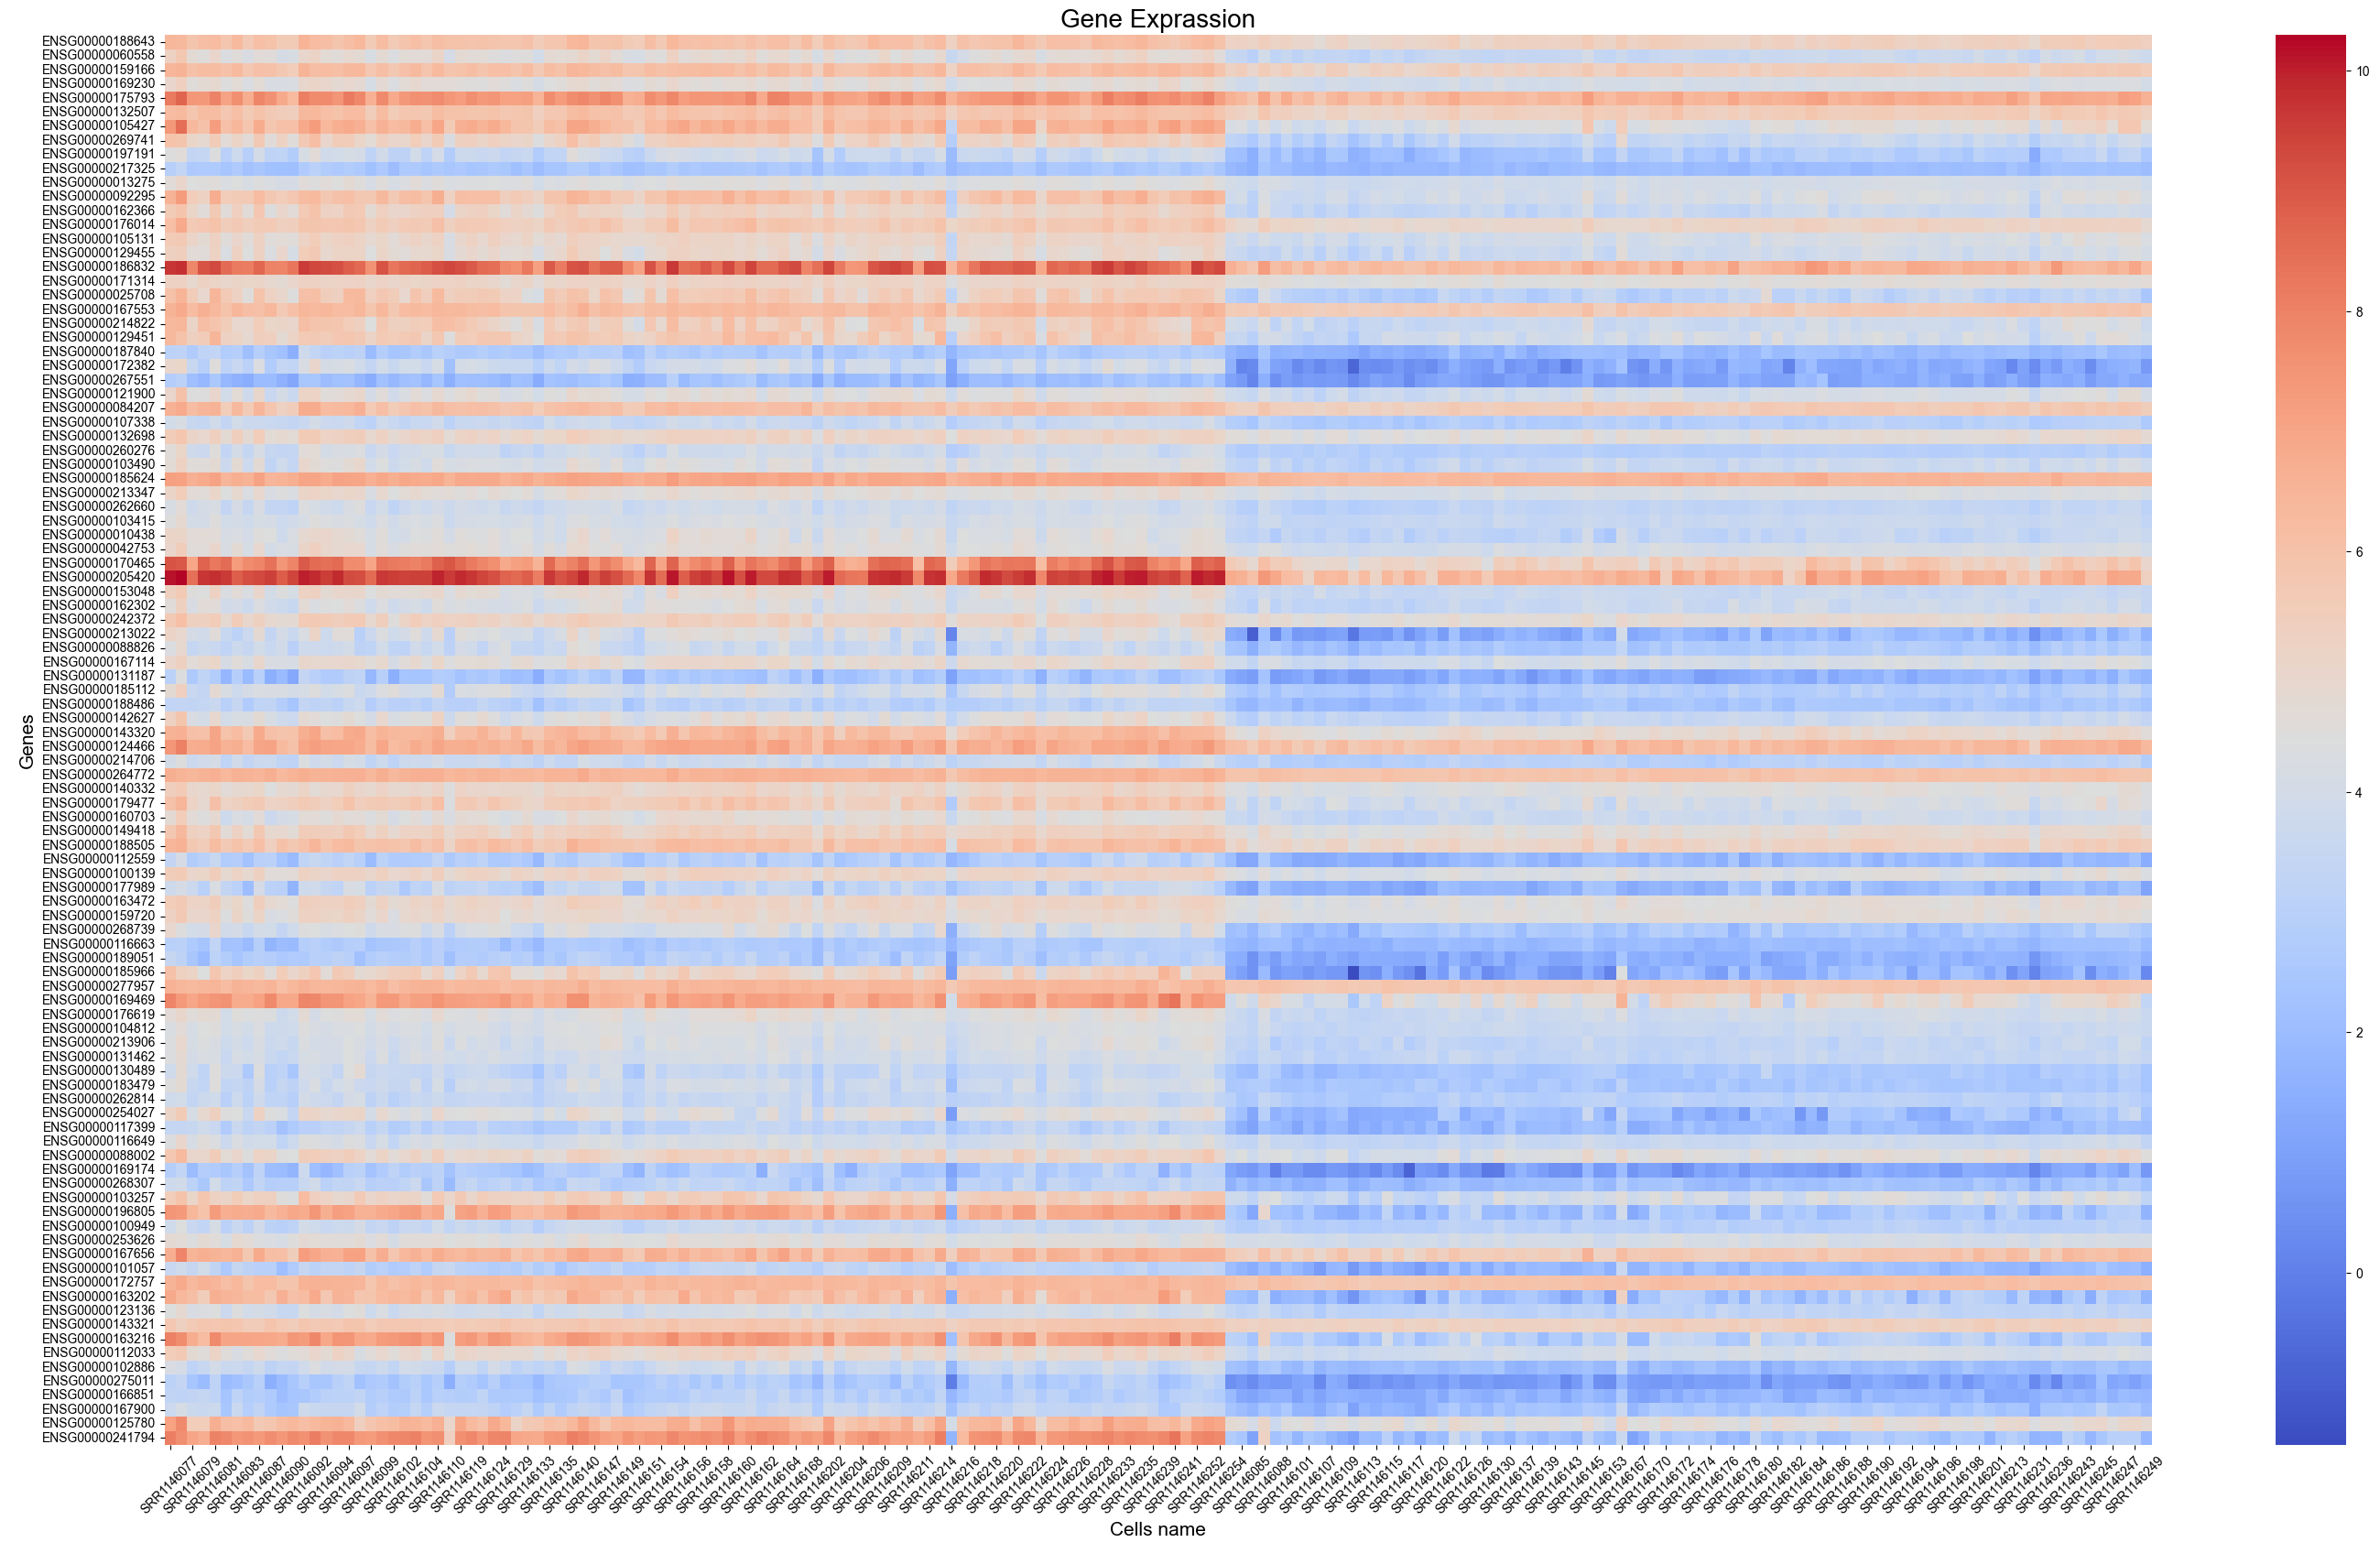

In [61]:
# Plot heat map of gene expresion 
fig, ax = plt.subplots(figsize=(35, 20))
sns.heatmap(sort_dframe,cmap='coolwarm')
ax.tick_params(axis='x', rotation=45)
sns.set(font_scale=1) # font size 2
plt.title('Gene Exprassion',fontsize=20)
plt.xlabel('Cells name',fontsize=15)
plt.ylabel('Genes',fontsize=15)

plt.show()

**Conclution** 

some genes have the same expresion in both kinds of cells.

some genes have hiest expresion in lisional cells 

## Exercise Part 2 : Solve a classification problem
“Things went pretty bad lately, it seems that the unknown disease spreads quite rapidly. People are concerned that the cure won’t be found soon, and once again “Pharmacom” turns to you for help - they would like you to be able to identify, based on a cheap test of blood- based mRNA gene-expression if a person is sick or not.
You should take into account the fact that a cheap test is limited by the data quality and volume that you get.”


**In this part we used three files:**
* Gene-level raw count matrix (features.rds)
* Sample annotation file (labels.rds)

In [5]:
# packges 
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split

### A) Basic classification 

#### 1. Load the dataset

In [6]:
raw_df= pd.read_csv('features.txt',index_col=0)
raw_df.head()

1         2         3         4         5         6   
SRR1146243  4.057059  2.805784  3.935262  3.866202  2.585520  2.244047  \
SRR1146244  3.318046 -2.362307  3.907833  3.333466  2.263786  2.973915   
SRR1146245  1.639190 -0.190798  3.699543  2.278955  1.167186  3.361633   
SRR1146246  3.290408 -1.708711  4.219863  4.175197  3.056383  3.329551   
SRR1146247  3.862546  0.766222  4.688288  3.523185  2.915453  2.239256   

                   7         8         9        10  ...     57832     57846   
SRR1146243  8.248893  5.426924  5.124292  4.481451  ...  3.363534  4.917973  \
SRR1146244  5.948596  4.329128  4.749798  4.002509  ...  2.807221  4.533203   
SRR1146245  4.688881  3.058311  4.283273  3.142480  ...  0.154673  4.091537   
SRR1146246  7.046470  5.097662  5.274118  4.607304  ...  3.620047  4.805418   
SRR1146247  7.580976  5.054629  5.158631  4.371582  ...  3.622427  4.438853   

               57885     57887     57908     57929     57932     57935   
SRR1146243  1.701393  0.283353  2.439566  2.496922  2.379835  2.538491  \
SRR1146244 -1.493196  1.191666  2.593325  0.309551  1.735091  1.758127   
SRR1146245 -2.599669 -0.645948  3.176501 -0.836355  2.655785  0.433192   
SRR1146246  0.230205  0.586779  2.776903  1.070299  2.372801  2.364449   
SRR1146247  0.560677  0.384685  2.629835 -0.671099  2.425151  2.402220   

               57954     57969  
SRR1146243  3.165511  1.947549  
SRR1146244  4.482234 -0.255909  
SRR1146245  3.693681  2.294530  
SRR1146246  5.759789  1.797104  
SRR1146247  4.799232  0.445766  

[5 rows x 15326 columns]

We know the cell's "name" but we don't know the gene's name

In [7]:
lables=pd.read_csv('labels.txt',index_col=0)
label_binarizer = LabelBinarizer()
lables['binary_target'] = label_binarizer.fit_transform( lables['target'])
lables.head()

target  binary_target
SRR1146243    normal              1
SRR1146244  lesional              0
SRR1146245  lesional              0
SRR1146246  lesional              0
SRR1146247  lesional              0

#### 2. Clean and analyze the data:

##### a. Print/Plot basic statistics- e.g., number of samples, genes, the range of values, some plots etc

In [8]:
#This function gets data, prints the dataframe shape, checks if there are any duplicates and removes them
#return df without duplicates

# print raw data shape, then remove the duplcate and print new shape
print (f"The raw data shape is: {raw_df.shape}")
if raw_df.duplicated().sum()!= 0:
    # remove the duplicate rows
    raw_df.drop_duplicates(keep=False, inplace=True)    
    print (f"The raw data shape  after removing duplicates is: {raw_df.shape[0]}")



The raw data shape is: (177, 15326)


In [9]:
# checking that all cells in label data are in the raw data

if (lables.index.unique()==raw_df.index.unique()).all():
    print ('All cells in the data and lables')

All cells in the data and lables


In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, SRR1146243 to SRR1146086
Columns: 15326 entries, 1 to 57969
dtypes: float64(15321), int64(5)
memory usage: 20.7+ MB


In [11]:
# Summary statistics of the numerical features
raw_df.describe()

1           2           3           4           5           6   
count  177.000000  177.000000  177.000000  177.000000  177.000000  177.000000  \
mean     4.145492    0.571615    4.515203    4.069799    2.937819    2.577649   
std      0.543215    1.353829    0.364453    0.356022    0.375741    0.526019   
min      1.639190   -3.512947    3.623589    2.278955    1.167186    0.841347   
25%      3.817609   -0.246323    4.296694    3.882404    2.694999    2.244047   
50%      4.077577    0.731856    4.502363    4.089323    2.954197    2.595625   
75%      4.460431    1.539274    4.715949    4.317935    3.171507    2.924907   
max      5.943467    3.600498    5.931868    4.852395    3.694264    3.944016   

                7           8           9          10  ...       57832   
count  177.000000  177.000000  177.000000  177.000000  ...  177.000000  \
mean     7.374468    5.111283    5.355951    4.324354  ...    4.078259   
std      0.841045    0.472812    0.340189    0.387084  ...    0.779544   
min      4.496301    3.058311    4.283273    3.142480  ...    0.154673   
25%      6.956956    4.850091    5.124292    4.076467  ...    3.622427   
50%      7.512147    5.145134    5.364785    4.335618  ...    4.130356   
75%      7.975280    5.396290    5.613928    4.617507  ...    4.649218   
max      9.051293    6.223072    6.224178    5.122709  ...    5.772715   

            57846       57885       57887       57908       57929       57932   
count  177.000000  177.000000  177.000000  177.000000  177.000000  177.000000  \
mean     4.561556    0.490772    0.471023    2.392272    1.201626    1.943760   
std      0.242823    0.769223    0.567305    0.452631    1.029569    0.529971   
min      3.997162   -2.599669   -0.802290    0.819407   -2.021974    0.022247   
25%      4.407576    0.071804    0.097898    2.072831    0.564009    1.662814   
50%      4.558080    0.647347    0.409539    2.399788    1.175697    1.998156   
75%      4.739171    1.043363    0.935886    2.725420    1.840469    2.287927   
max      5.157385    1.812578    1.728885    3.301608    3.611210    2.955300   

            57935       57954       57969  
count  177.000000  177.000000  177.000000  
mean     2.548781    4.078193    1.202643  
std      0.403301    0.704604    0.826235  
min      0.433192    2.565109   -0.978539  
25%      2.345632    3.617540    0.619493  
50%      2.541898    3.996593    1.139034  
75%      2.799987    4.563208    1.796796  
max      3.735676    5.759789    3.354625  

[8 rows x 15326 columns]

In [12]:
raw_df.T.describe() # statistic infornation to each column 

SRR1146243    SRR1146244    SRR1146245    SRR1146246    SRR1146247   
count  15326.000000  15326.000000  15326.000000  15326.000000  15326.000000  \
mean       8.008499      7.555840      7.014066      7.943766      7.748042   
std      318.493284    318.500357    318.509536    318.494602    318.497622   
min    -5432.000000  -5432.000000  -5432.000000  -5432.000000  -5432.000000   
25%        3.016577      2.372276      1.589550      2.903361      2.624889   
50%        4.439095      4.028795      3.430214      4.414465      4.239822   
75%        5.666831      5.410205      5.169875      5.682946      5.548871   
max    22332.000000  22332.000000  22332.000000  22332.000000  22332.000000   

         SRR1146248    SRR1146249    SRR1146250    SRR1146252    SRR1146253   
count  15326.000000  15326.000000  15326.000000  15326.000000  15326.000000  \
mean       7.783077      7.877054      7.571471      7.779631      7.936890   
std      318.497203    318.496032    318.500783    318.497720    318.494698   
min    -5432.000000  -5432.000000  -5432.000000  -5432.000000  -5432.000000   
25%        2.697626      2.779906      2.408826      2.564402      2.884315   
50%        4.260192      4.359966      4.151885      4.268941      4.381986   
75%        5.554693      5.723877      5.514604      5.718053      5.701645   
max    22332.000000  22332.000000  22332.000000  22332.000000  22332.000000   

       ...    SRR1146077    SRR1146078    SRR1146079    SRR1146080   
count  ...  15326.000000  15326.000000  15326.000000  15326.000000  \
mean   ...      7.835961      7.916653      7.854128      7.829330   
std    ...    318.496137    318.494758    318.496054    318.496206   
min    ...  -5432.000000  -5432.000000  -5432.000000  -5432.000000   
25%    ...      2.729432      2.845996      2.737058      2.694999   
50%    ...      4.256824      4.338429      4.307330      4.255312   
75%    ...      5.599019      5.612584      5.632879      5.593809   
max    ...  22332.000000  22332.000000  22332.000000  22332.000000   

         SRR1146081    SRR1146082    SRR1146083    SRR1146084    SRR1146085   
count  15326.000000  15326.000000  15326.000000  15326.000000  15326.000000  \
mean       7.763173      7.807642      7.923332      7.721842      7.589806   
std      318.497400    318.496509    318.494801    318.497847    318.500729   
min    -5432.000000  -5432.000000  -5432.000000  -5432.000000  -5432.000000   
25%        2.639749      2.700634      2.876099      2.592462      2.346228   
50%        4.221472      4.235258      4.384381      4.189023      4.132627   
75%        5.568450      5.575148      5.659180      5.530726      5.559830   
max    22332.000000  22332.000000  22332.000000  22332.000000  22332.000000   

         SRR1146086  
count  15326.000000  
mean       7.817645  
std      318.496742  
min    -5432.000000  
25%        2.716275  
50%        4.308178  
75%        5.615044  
max    22332.000000  

[8 rows x 177 columns]

In [13]:
raw_df.shape

(177, 15326)

In [14]:
def if_missing_valuedf_check(df_check):
    '''
    This function checking if there are any missing values in the dataframe 
    Input:
    ======
    df_check : DataFrame 
    
    Output:
    =======
    list_nan_col: CPM normalization DataFrame

    '''  
    contain_nan_df=df_check.loc[:, df_check.isnull().any()]
    number_of_line_with_nan=df_check.isna().any(axis=1).sum()
    print (f'This genes list {contain_nan_df.columns.tolist()}  that contains nan vallues and the number of rows with missing value are {number_of_line_with_nan } ')
    return contain_nan_df.columns.tolist()


In [15]:
col_with_nan=if_missing_valuedf_check(raw_df)

This genes list ['286', '287', '288', '289', '290', '291', '292', '294', '295', '296', '297']  that contain nan vallues  and the number of rows with missing value are 4 


**Note**

Since I don't like remove rows/columns with missing data , I decided to complete the mising data
I know that there is a possibility that the completion could create a bias, in the future I will perhaps consider lowering the columns because I have enough features.


Several aprouch to missing value:
1. remove the genes 
2. fill the nan by mean 

In [16]:
# Imputing missing values by mean of the column
mean_imputer = SimpleImputer( strategy='mean')
mean_imputer = mean_imputer.fit(raw_df)
fill_raw_df = pd.DataFrame(mean_imputer.transform(raw_df.loc[:,:]), columns =raw_df.columns,index=raw_df.index) # create a new dataframe using the result returned by the transform() 

we desided not to remove lines (samples) because we don't have a lot of them

In [17]:
# check that we don't have any surprises 
res=if_missing_valuedf_check(fill_raw_df)
if len(res):
    print ('We have missing values!! check the code ')
else:
    print ('We do not have missing values')


This genes list []  that contain nan vallues  and the number of rows with missing value are 0 
We do not have missing values


#### Cheking the lable balance 

if we have an unbalanced data we can do up-sampling or down-sampling

In [18]:
# Count each cell type amount
count=lables['target'].value_counts( )
count


target
lesional    94
normal      83
Name: count, dtype: int64

In [19]:
print (f'lesional cell are  {count[0]} and normal cells are {count[1]}')

lesional cell are  94 and normal cells are 83


##### PCA plot and remove outliers 

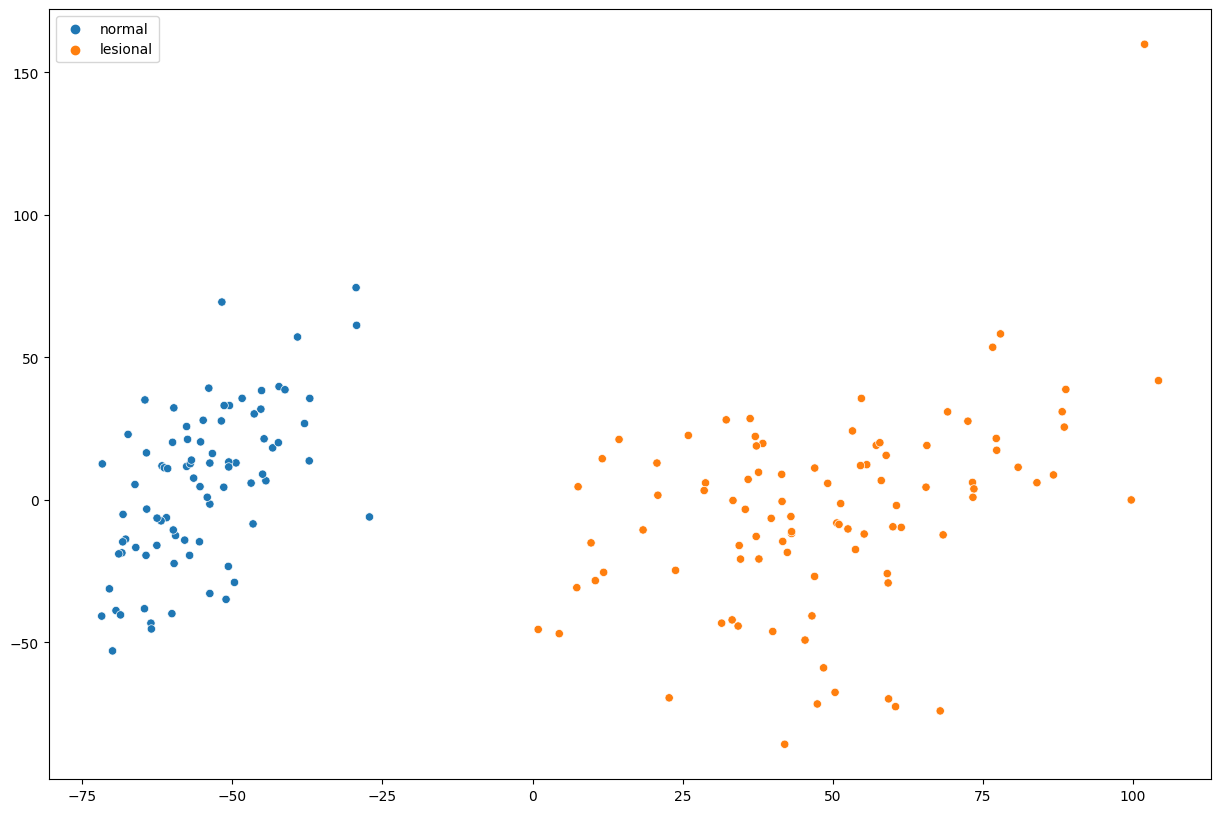

In [21]:
#from sklearn.decomposition import PCA

pca_r = PCA().fit_transform(fill_raw_df.copy())
plt.figure(figsize = (15,10) )
sns.scatterplot(x=pca_r[:,0], y=pca_r[:,1], hue = lables['target'].values )
plt.show()

/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_49429/3131523741.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=fill_raw_df[j])
/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_49429/3131523741.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=fill_raw_df[j])
/var

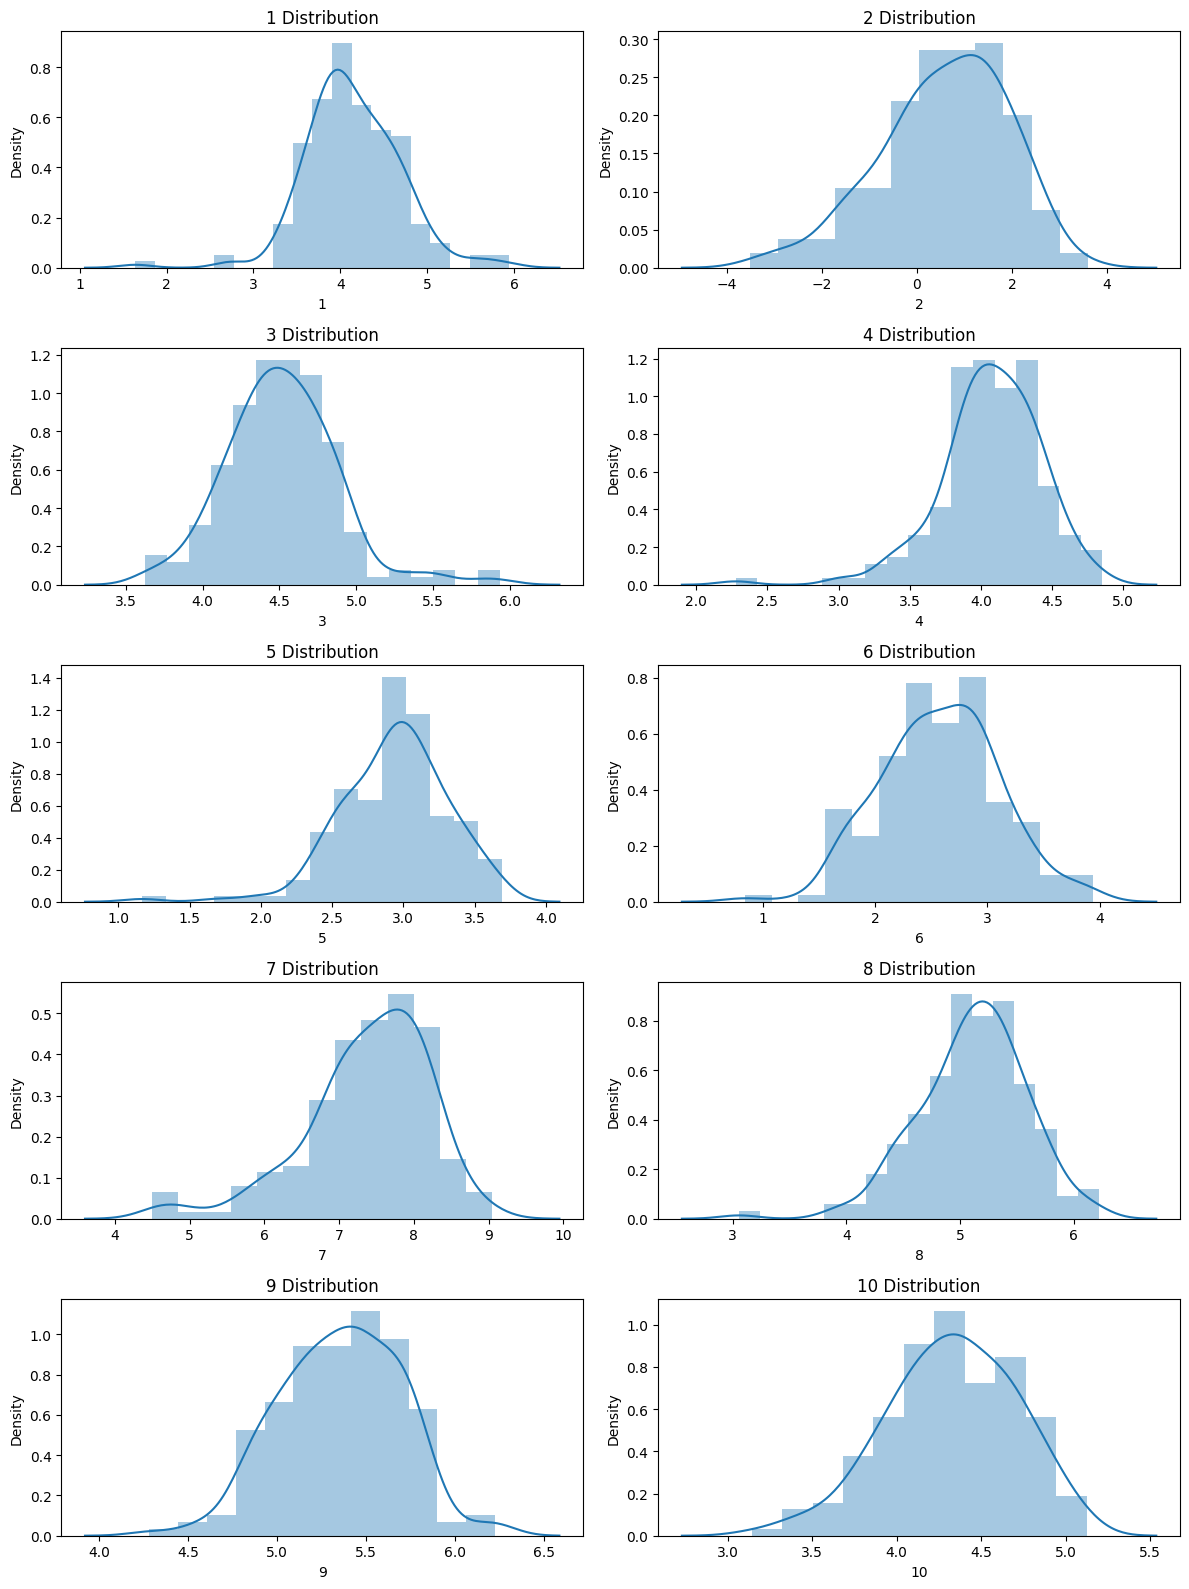

In [22]:
# Visualize the distribution of each 10 first variables (we can do for all but it take time-a lot of time)
plt.figure(figsize=(12,16))
for i, j in enumerate(fill_raw_df.describe().columns[0:10]):
    plt.subplot(5,2, i+1)
    sns.distplot(x=fill_raw_df[j])
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()

#### BOX-PLOT
In descriptive statistics, the boxplot is one method for graphically representing numerical data using the following measures:

* Median: In the box plot, the median is displayed rather than the mean.

* Q1: The first quartile (25%) position.

* Q3: The third quartile (75%) position.

* Interquartile range (IQR): a measure of statistical dispersion equal to the difference between 75th and 25th percentiles.  It represents how 50% of the points were dispersed.

* Lower and upper 1.5*IQR whiskers represent the outliers’ limits and boundaries.

* Outliers: Defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR. Outliers are displayed as dots or circles.


In [ ]:
def box_plot_feature(df_features):
    '''
    Visualize the boxplot of  11 variable.
    We need to to all - it take time - I desice to do for less 
    Input:
    ======
    df_features: pd.DataFrame -> the data that we what plot
    '''
    # Visualize the boxplot of  11 variable.
    # We need to to all - it take time - I desice to do for less 
    plt.figure(figsize=(12,10))
    for i, j in enumerate(df_features.describe().columns[0:10]):
        plt.subplot(5,2, i+1)
        sns.boxplot(x=df_features[j])
        plt.title('{} Boxplot'.format(j))
        plt.tight_layout()
        
plt.show()

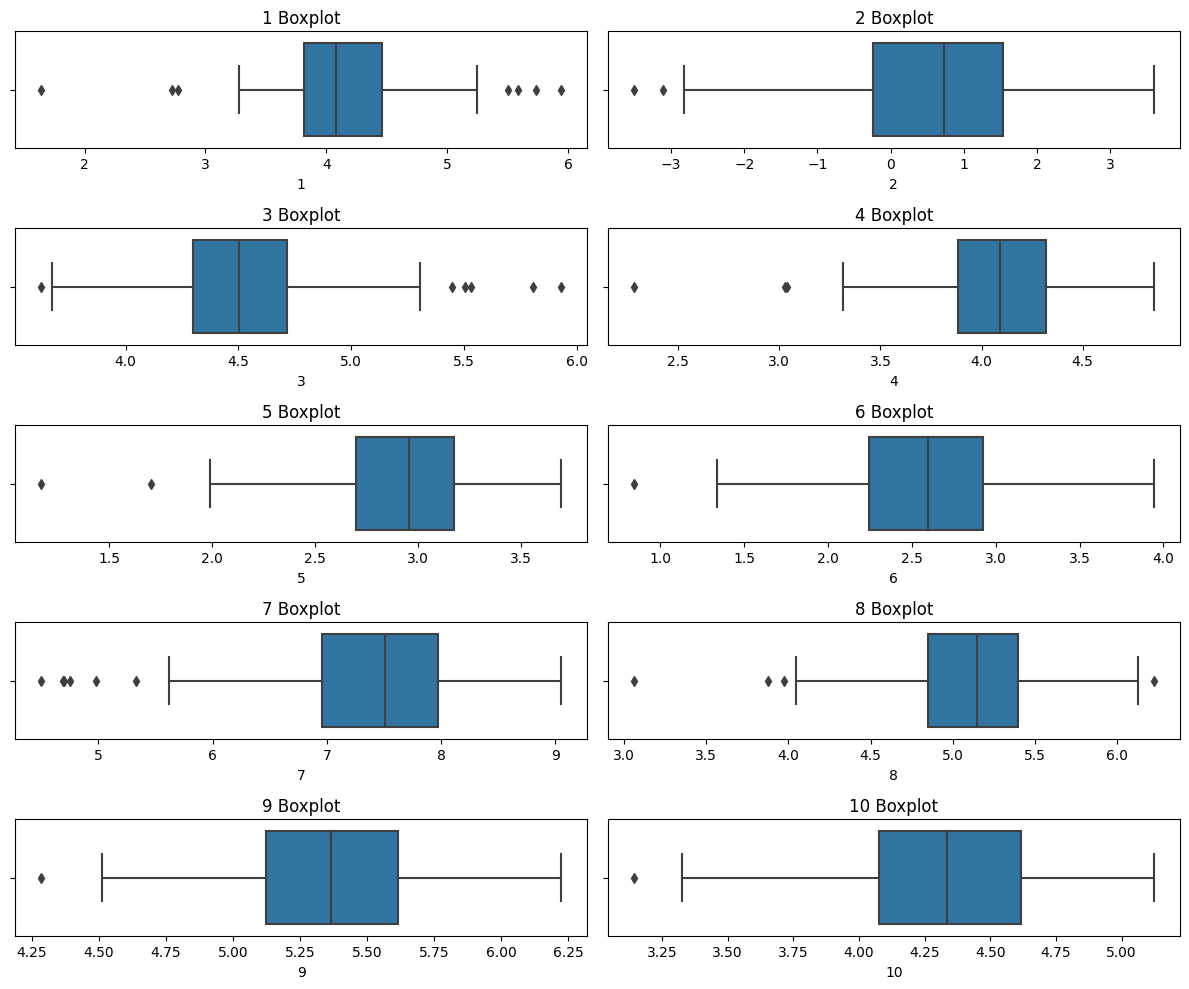

In [23]:
# Visualize the boxplot of 11 variables.
# We need to do for all - it takes  long time - I decied to do for less 


box_plot_feature(fill_raw_df)


We will not currently delete outlires, some are vary high, while others are very low.
Therefore, we must recheck outliers after choosing the best features we want to use for clustering.

After we choose the best feature, we will plot correlation heatmap  

#### Multivariate Analysis
Multivariate analysis is used to analyze more than two variables simultaneously. In addition, this analysis will assist us in determining the correlation between all variables in the dataset.
We can use .pairplot() to display a group of scatterplots of each variable in the dataset.

 **It take time we have alot of variables**

In [81]:
# # we have to mach feater and it didn't wort i will try again after feature selaction 
# pairplot = sns.pairplot(fill_raw_df, corner=True)
# plt.show(pairplot)

Did't work for me because of too much data .. I'll try after feature selction 

#### Correlation plot



Correlation is a statistical method for determining whether numerical or categorical variables are related. It’s a way of determining how things are connected.

we can use .heatmap() function combined with the .corr() function to display the relationship between each variable in the dataset based on the correlation coefficient.

In [ ]:
# correlation_metrics=fill_raw_df.corr()
# fig = plt.figure(figsize=(14,9))
# sns.heatmap(correlation_metrics,square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')
# plt.title('Correlation Between Variables', size=14)
# plt.show()

Did't wort will do after feature selaction 

##### b. Make sure the data is “clean” and is usable.

In [26]:
# add to raw data the labels 
raw_labels_df=fill_raw_df.join(lables['target'],how='outer') # add cell type to the data frame, join by index -> cell abriveation
raw_labels_df.head()

1         2         3         4         5         6   
SRR1146243  4.057059  2.805784  3.935262  3.866202  2.585520  2.244047  \
SRR1146244  3.318046 -2.362307  3.907833  3.333466  2.263786  2.973915   
SRR1146245  1.639190 -0.190798  3.699543  2.278955  1.167186  3.361633   
SRR1146246  3.290408 -1.708711  4.219863  4.175197  3.056383  3.329551   
SRR1146247  3.862546  0.766222  4.688288  3.523185  2.915453  2.239256   

                   7         8         9        10  ...     57846     57885   
SRR1146243  8.248893  5.426924  5.124292  4.481451  ...  4.917973  1.701393  \
SRR1146244  5.948596  4.329128  4.749798  4.002509  ...  4.533203 -1.493196   
SRR1146245  4.688881  3.058311  4.283273  3.142480  ...  4.091537 -2.599669   
SRR1146246  7.046470  5.097662  5.274118  4.607304  ...  4.805418  0.230205   
SRR1146247  7.580976  5.054629  5.158631  4.371582  ...  4.438853  0.560677   

               57887     57908     57929     57932     57935     57954   
SRR1146243  0.283353  2.439566  2.496922  2.379835  2.538491  3.165511  \
SRR1146244  1.191666  2.593325  0.309551  1.735091  1.758127  4.482234   
SRR1146245 -0.645948  3.176501 -0.836355  2.655785  0.433192  3.693681   
SRR1146246  0.586779  2.776903  1.070299  2.372801  2.364449  5.759789   
SRR1146247  0.384685  2.629835 -0.671099  2.425151  2.402220  4.799232   

               57969    target  
SRR1146243  1.947549    normal  
SRR1146244 -0.255909  lesional  
SRR1146245  2.294530  lesional  
SRR1146246  1.797104  lesional  
SRR1146247  0.445766  lesional  

[5 rows x 15327 columns]

#### Feature Selection and Features Outliers Handaling 
We need to select features to use in the clustering process.
To determine the best features, we need to review the purpose of this project.

we have 177 samples and ~15000 features, we need reduce umber of genes -> customary to reduse the number to sqrt(n), in out case is sqrt(177)-> ~15 


In [32]:
#Principal components - 2 principal components for data without outliers 
from pca import pca
cmp=2
# Our data has different scales so we need to standard it (this will effect the variance)
# StandardScaler- this step  ensures that all features are on the same scales and have similar ranges. 
# using the pca to remove outliers and fine most segnificent - higt variance features - feature selection 

results=find_outliers(raw_labels_df,'target')
Xnormal=raw_labels_df.loc[~results['outliers']['y_bool_spe']].drop(['target'],axis=1) # remove the binary_type column
standard = StandardScaler()
scaled_data = standard.fit_transform(Xnormal)
pca_c = PCA(n_components=cmp)
components = pca_c.fit_transform(scaled_data)
plot_pca(components,pca_c,'PCA afterStandarScaler -remove the outliers ',raw_labels_df.loc[~results['outliers']['y_bool_spe'],'target'])


[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [15326] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [89] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [15326] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[89]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
                  y_proba          p_raw      y_score  y_bool  y_bool_spe   
SRR1146243   1.000000e+00   9.999535e-01   113.560127   False       False  \
SRR1146244  1.350229e-203  1.373114e-204  1483.988327    True        True   
SRR1146245   0.0

In [33]:
#remove the outliets 
raw_labels_noOUtlieres_df=raw_labels_df.loc[~results['outliers']['y_bool_spe']] # df withou outliers # get the data after filling the Na, and removeing the outliers split to train and test, save the proportions of each class 
raw_labels_noOUtlieres_df['binary_target'] = label_binarizer.fit_transform( raw_labels_noOUtlieres_df['target']) # convert to 0 and 1 the target 



/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_49429/2584061985.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
# save to pkl 
raw_labels_noOUtlieres_df.to_pickle('data_make_model.pkl')

### Feature sellection 


**SelectKBest** has two important parameters:

* score_func: the filter function that is used for feature selection

* k: the number of top features to select

Let's demonstrate **SelectKBest** by using ANOVA F-value as our filter method. We will select the top 15 features based on the ANOVA F-value.

In [38]:
raw_labels_noOUtlieres_df[:-2].head()

1         2         3         4         5         6   
SRR1146243  4.057059  2.805784  3.935262  3.866202  2.585520  2.244047  \
SRR1146246  3.290408 -1.708711  4.219863  4.175197  3.056383  3.329551   
SRR1146247  3.862546  0.766222  4.688288  3.523185  2.915453  2.239256   
SRR1146248  3.634959 -0.931574  4.259167  3.813203  2.921527  3.840881   
SRR1146250  4.062653 -1.834858  4.998398  3.962486  3.287832  1.764174   

                   7         8         9        10  ...     57885     57887   
SRR1146243  8.248893  5.426924  5.124292  4.481451  ...  1.701393  0.283353  \
SRR1146246  7.046470  5.097662  5.274118  4.607304  ...  0.230205  0.586779   
SRR1146247  7.580976  5.054629  5.158631  4.371582  ...  0.560677  0.384685   
SRR1146248  5.994945  4.544843  4.835037  4.183357  ...  0.480885  1.344372   
SRR1146250  4.982268  4.454941  6.222373  3.999944  ... -0.852839  1.115437   

               57908     57929     57932     57935     57954     57969   
SRR1146243  2.439566  2.496922  2.379835  2.538491  3.165511  1.947549  \
SRR1146246  2.776903  1.070299  2.372801  2.364449  5.759789  1.797104   
SRR1146247  2.629835 -0.671099  2.425151  2.402220  4.799232  0.445766   
SRR1146248  3.265829  0.665574  1.687021  2.262783  4.659640  0.714273   
SRR1146250  2.140216  1.410711  1.425470  3.060892  3.208988  1.040722   

              target  binary_target  
SRR1146243    normal              1  
SRR1146246  lesional              0  
SRR1146247  lesional              0  
SRR1146248  lesional              0  
SRR1146250  lesional              0  

[5 rows x 15328 columns]

In [40]:
# feature extraction
#
array= raw_labels_noOUtlieres_df.values
X=raw_labels_noOUtlieres_df.drop(['target','binary_target'],axis=1).values
y=raw_labels_noOUtlieres_df['target'].values
feature_names=raw_labels_noOUtlieres_df.columns
skb = SelectKBest(score_func=f_classif,# Set f_classif as our criteria to select features
                   k=15) # # Select top 15 features based on the criteria
X_new = skb.fit_transform(X, y)
# Print the results
print('Number of features before feature selection: {}'.format(X.shape[1]))
print('Number of features after feature selection: {}'.format(X_new.shape[1]))


Number of features before feature selection: 15326
Number of features after feature selection: 15


/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   32    33 11999 12000 12001] are constant.

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide



As we can see, **SelectKBest** automatically eliminate two features that have the lowest F-value.

We can identify the name of selected features by calling **get_support** method.




In [41]:
# Print the name of the selected features
feature_list=[]
for feature_list_index in skb.get_support(indices=True):
    feature_list.append(feature_list_index)
    print('- ' + feature_names[feature_list_index])

- 10955
- 11419
- 11606
- 13129
- 14145
- 14260
- 15718
- 16130
- 16706
- 17242
- 17648
- 20379
- 20380
- 27528
- 36295


In [42]:
df_learn_on=raw_labels_noOUtlieres_df.iloc[:,feature_list]
df_learn_on['target']=raw_labels_noOUtlieres_df['target']
df_learn_on

/var/folders/nk/mhz4rj4n5yz2gvzf2vjlftn80000gp/T/ipykernel_49429/3545176763.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



10955     11419      11606      13129     14145     14260   
SRR1146243   4.308025  5.727996   7.398103  -1.974491  1.491658 -1.974491  \
SRR1146246  12.410286  8.219793  10.235525   6.946147  3.076976  5.640342   
SRR1146247  12.338663  9.004148  10.195443   6.797499  3.393541  5.298698   
SRR1146248  13.861102  9.551355  11.163348   9.933009  4.028289  8.958788   
SRR1146250  13.112269  9.664387  10.528051   8.614204  4.034049  7.447554   
...               ...       ...        ...        ...       ...       ...   
SRR1146082   4.777619  6.695395   6.767262  -4.022917  1.996611 -7.169979   
SRR1146083   1.965432  5.914812   6.162895  -7.169979  1.299516 -7.169979   
SRR1146084  13.141241  8.873766  11.198658  10.258281  3.879826  8.620052   
SRR1146085  13.379499  9.182125  11.363575   8.746008  4.429071  7.416592   
SRR1146086  12.952492  9.048768  11.101663   9.783662  3.648150  8.761433   

                15718     16130     16706      17242     17648     20379   
SRR1146243   0.908476 -4.012807  1.840833   4.171573  1.010472  1.701393  \
SRR1146246   9.797190  6.169996  6.139115   9.358251  6.610532  8.254389   
SRR1146247   8.774828  5.127511  6.061813   8.699727  6.573778  7.155852   
SRR1146248  10.794693  6.362672  7.370942  10.638626  7.636969  9.924263   
SRR1146250  10.079300  5.812126  7.148059   9.925449  7.557576  8.790932   
...               ...       ...       ...        ...       ...       ...   
SRR1146082  -0.276648 -2.550831  2.682352   4.524098  0.396866  3.693792   
SRR1146083  -7.169979 -4.803056  0.025210   2.509861 -0.016320  1.589821   
SRR1146084  11.121927  6.737581  7.216738  10.433352  7.192754  9.642731   
SRR1146085  11.113606  5.804554  7.616284  10.641167  7.296810  9.660758   
SRR1146086  10.887566  7.188331  7.317623  10.196834  7.400205  9.525535   

                20380     27528      36295    target  
SRR1146243  -0.313846 -1.826430   4.090050    normal  
SRR1146246   9.495987  3.654709  10.237420  lesional  
SRR1146247   8.101244  3.397412   9.820035  lesional  
SRR1146248  11.246168  4.724969  11.602545  lesional  
SRR1146250   9.860623  4.095324  10.832581  lesional  
...               ...       ...        ...       ...  
SRR1146082   1.690025 -1.362380   4.450391    normal  
SRR1146083  -0.847878 -2.472295   2.688504    normal  
SRR1146084  11.050418  3.869339  11.377998  lesional  
SRR1146085  10.956020  3.609999  11.519107  lesional  
SRR1146086  11.038683  4.845236  11.339917  lesional  

[162 rows x 16 columns]

#### now we have less features, lets plots - all plots are like histograma and heatmaps of corelation that didn't work becouse of the data size

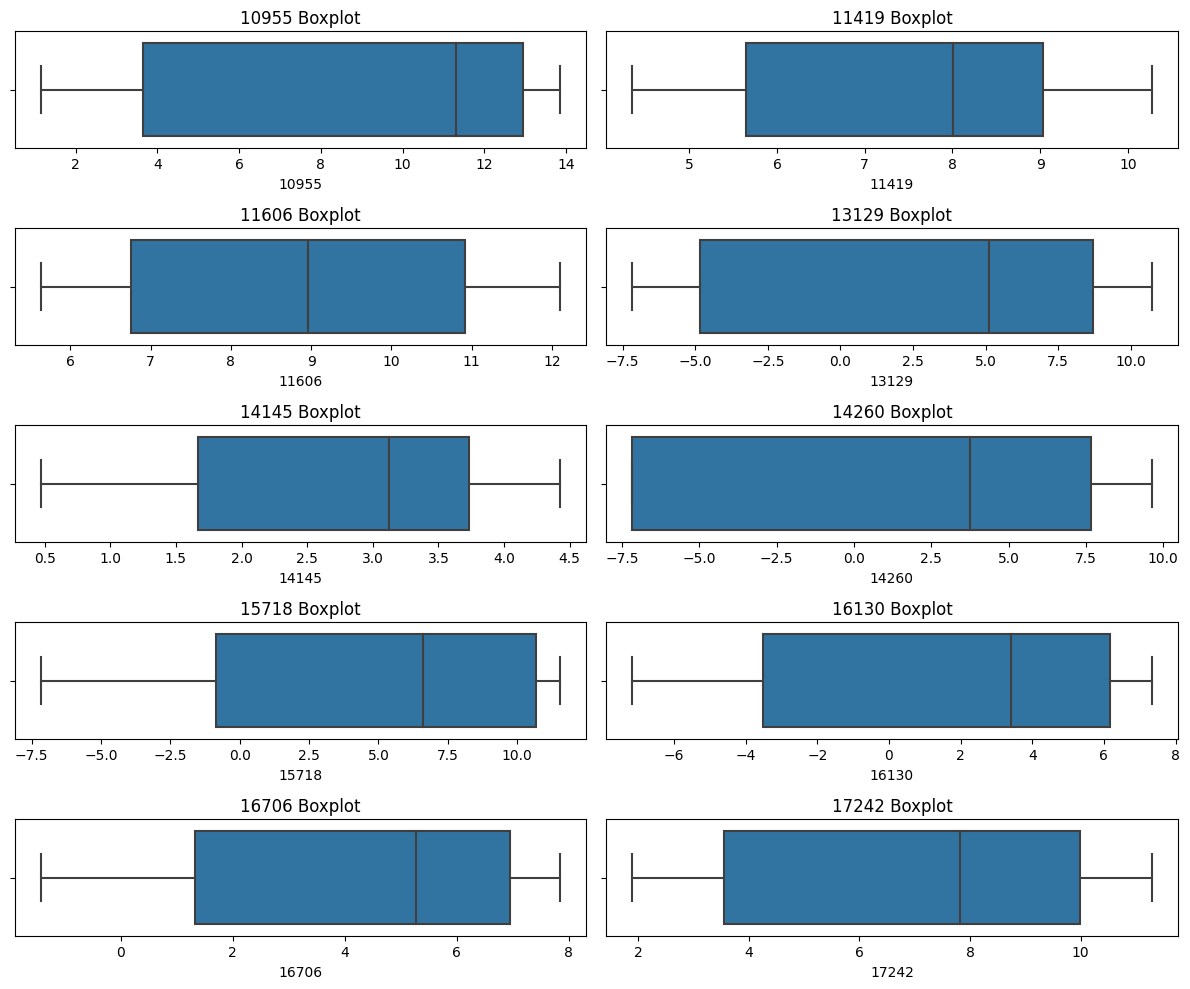

In [44]:
box_plot_feature(df_learn_on)

We don't have any outliers 

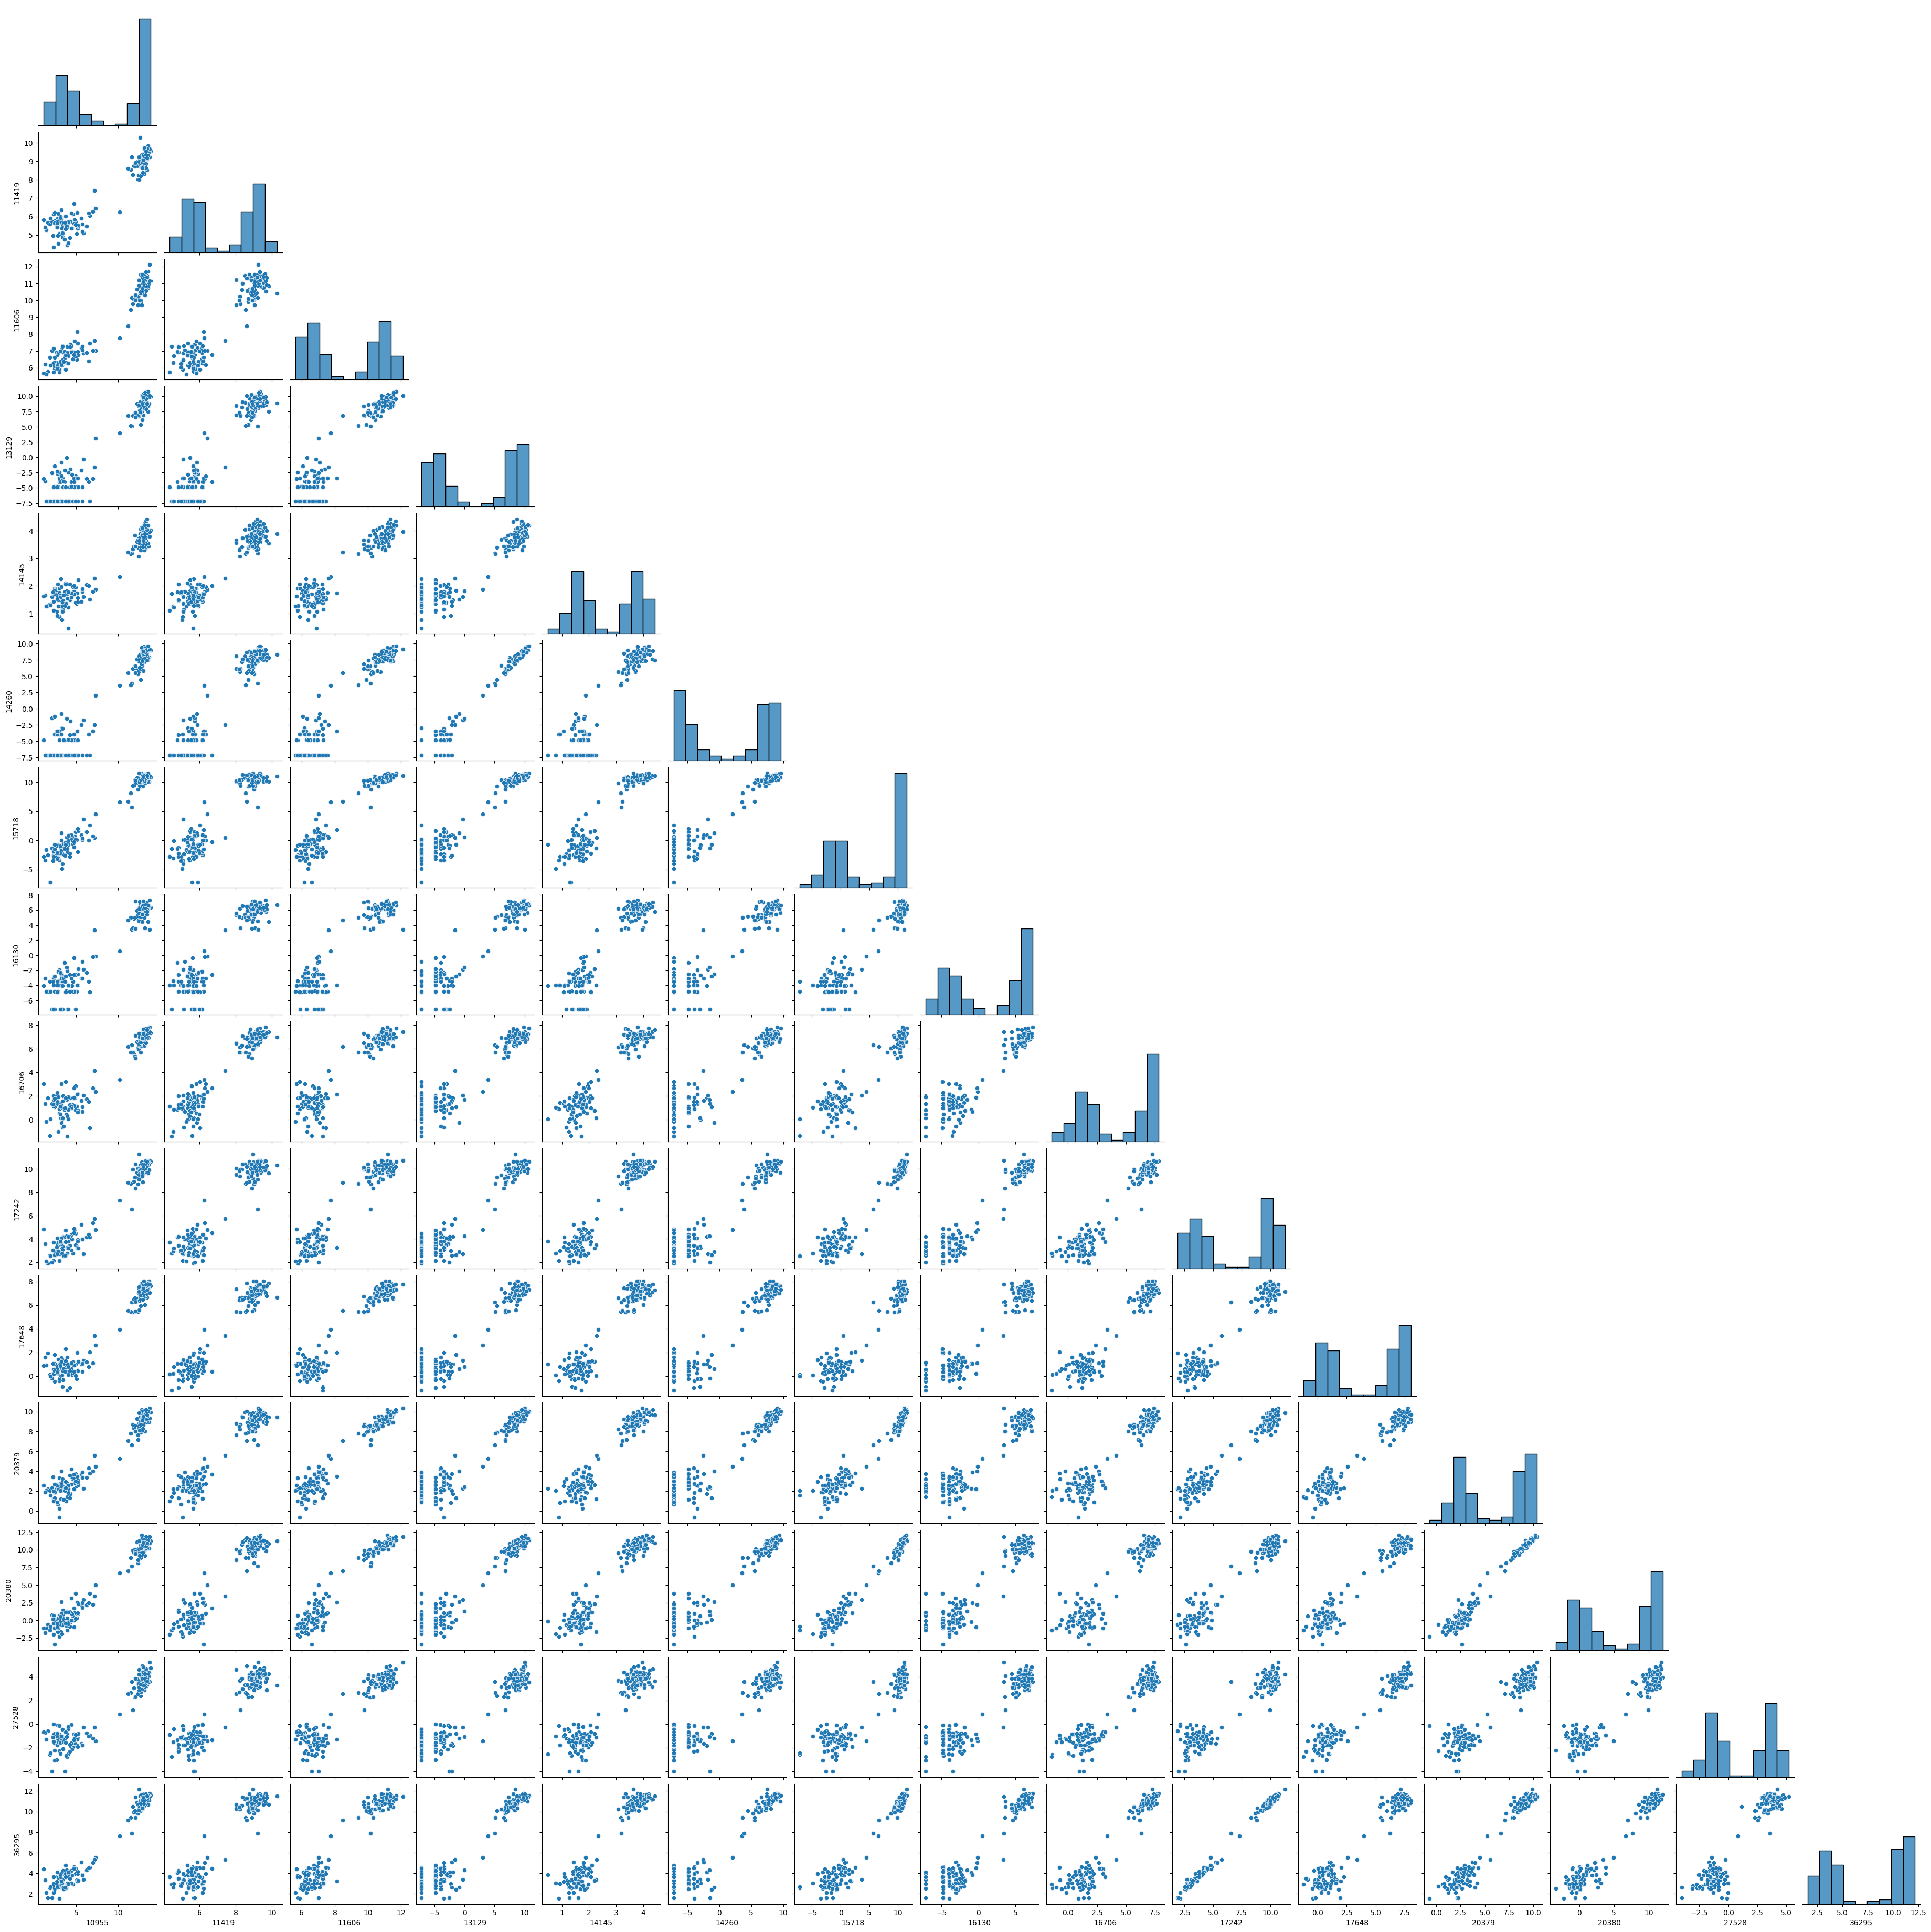

In [100]:
# pair plots - allows us to see both distribution of single variables and relationships between two variables 
pairplot = sns.pairplot(df_learn_on.drop('target',axis=1), corner=True)
plt.show(pairplot)



The features look like corelated 

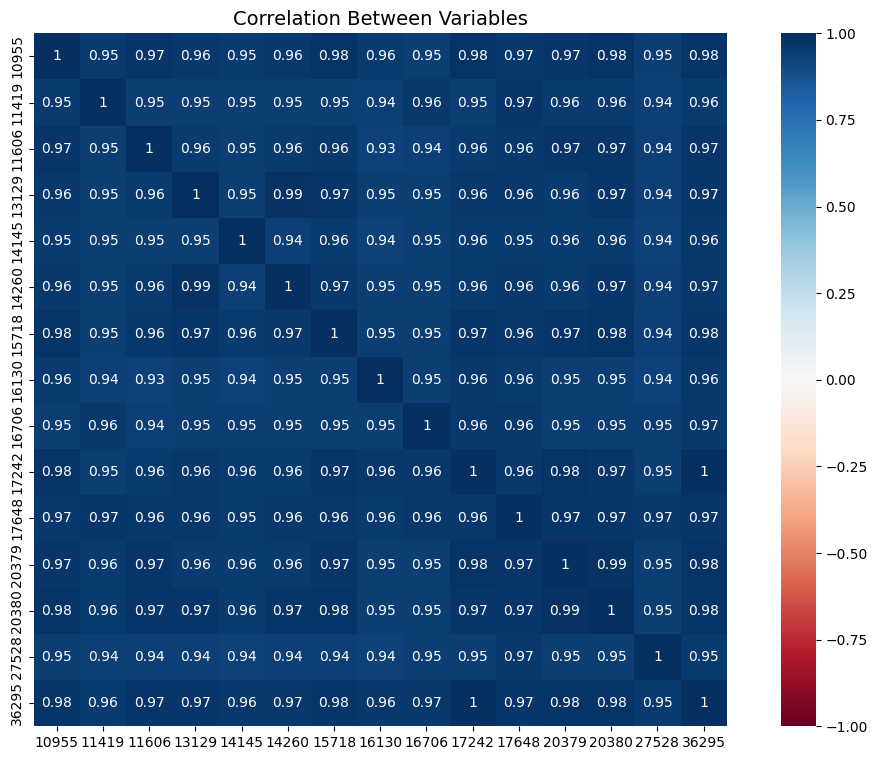

In [46]:
correlation_metrics=df_learn_on.drop(['target'],axis=1).corr()
fig = plt.figure(figsize=(14,9))
sns.heatmap(correlation_metrics,square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')
plt.title('Correlation Between Variables', size=14)
plt.show()

#### 4. Train at least two classifiers - identify “lesional”/”normal”.

##### a. At least one of them should have some sort of regularization, evaluate its performance


We need to do some steps:

1. K-folds :
   * split the data into k-subsets and the holdout method is repeated k-times where each of the k subsets are used as test set and other k-1 subsets are used for the training purpose.
    helps us to avoid overfitting - we have a lot of features and only ~ 200 sampels 
2. grid search
3. model regularization
4. compare model performance -I choose Acurracy 

In [47]:
raw_labels_noOUtlieres_df=pd.read_pickle('data_make_model.pkl')
raw_labels_noOUtlieres_df.head()

1         2         3         4         5         6   
SRR1146243  4.057059  2.805784  3.935262  3.866202  2.585520  2.244047  \
SRR1146246  3.290408 -1.708711  4.219863  4.175197  3.056383  3.329551   
SRR1146247  3.862546  0.766222  4.688288  3.523185  2.915453  2.239256   
SRR1146248  3.634959 -0.931574  4.259167  3.813203  2.921527  3.840881   
SRR1146250  4.062653 -1.834858  4.998398  3.962486  3.287832  1.764174   

                   7         8         9        10  ...     57885     57887   
SRR1146243  8.248893  5.426924  5.124292  4.481451  ...  1.701393  0.283353  \
SRR1146246  7.046470  5.097662  5.274118  4.607304  ...  0.230205  0.586779   
SRR1146247  7.580976  5.054629  5.158631  4.371582  ...  0.560677  0.384685   
SRR1146248  5.994945  4.544843  4.835037  4.183357  ...  0.480885  1.344372   
SRR1146250  4.982268  4.454941  6.222373  3.999944  ... -0.852839  1.115437   

               57908     57929     57932     57935     57954     57969   
SRR1146243  2.439566  2.496922  2.379835  2.538491  3.165511  1.947549  \
SRR1146246  2.776903  1.070299  2.372801  2.364449  5.759789  1.797104   
SRR1146247  2.629835 -0.671099  2.425151  2.402220  4.799232  0.445766   
SRR1146248  3.265829  0.665574  1.687021  2.262783  4.659640  0.714273   
SRR1146250  2.140216  1.410711  1.425470  3.060892  3.208988  1.040722   

              target  binary_target  
SRR1146243    normal              1  
SRR1146246  lesional              0  
SRR1146247  lesional              0  
SRR1146248  lesional              0  
SRR1146250  lesional              0  

[5 rows x 15328 columns]

##### b. Evaluate and compare the performance of the two (or more) models

### B) Let’s make it more complicated

You are told that we cannot use the actual samples to train a model, rather use some statistics as a reference for the distribution of the data 

#### 1. For each group lesional/normal you can create up to 5 meta-samples that represent the data.

#### 2. Use those meta-samples to train new models (i.e. don’t train on the original samples, but you can test on the original samples)

##### a. You should minimally train the same type of models used in part A

##### b. Evaluate models performance and compare to those used in part A


#### 2. Use those meta-samples to train new models (i.e. don’t train on the original samples, but you can test on the original samples)

# **Notes**


* Create meta-samples from the data with all the features.
    In real life, it can happen that the test set has a different distribution, so it would be more correct to perhaps calculate the average and the standard deviation to create a meta sample only from the part of the train, let's have only 5 samples in the meta sample from each group, I calculated the average and standard deviation on train data only.
    This will be the **train_meta**, and all the **test_df** data will be **test_meta** - the test data set
    the meta data create data whose features will have a similar mean (similar distribution) and a similar standard deviation

    For this we will arm each feature with an average and standard deviation according to its class. We will use these parameters to generate data

* split the data that has on the data without the outliers and that the has imputation into train_df and test_df

We will write a model that tries to predict whether the cells are normal or lesion using 3 models.
We will perform an evaluation for each of them, as well as do a grid search for the hyperparameters of the models.
And finally we will compare the models.

In [48]:
def meta_samples_generation(df,meta_semple_num,target):
    
    '''
    This function generate  meta-semple
    get df-> train_df to spesific las, calculate the mean and the std and generate new values 
    Input:
    =====
    df : pd.DataFrame - contain the data of train semples 
    meta_semple_num: number of sample to generate 
    target: kind od class
    
    output:
    =======
    df_meta: pd.Dataframe -> contain new data frae with meta samples 
    '''
    # calculate mean to each feature and std
    means_x=df.mean() # mean calculation 
    stds_x=df.std() # std calculation

    # random sample using the mean and the std of the data from the original data set (the train set)
    df_meta= pd.DataFrame(np.random.normal(means_x,stds_x,size=(5,df.shape[1])),columns=df.columns)
    df_meta['binary_target']= target
    return df_meta




In [49]:
# Prepare data to Classification
X=raw_labels_noOUtlieres_df.drop(['target','binary_target'],axis=1)
y=raw_labels_noOUtlieres_df['binary_target']
# stratify -  split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=raw_labels_noOUtlieres_df['binary_target'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(129, 15326)
(33, 15326)
(129,)
(33,)


In [50]:
# Create the meta data 
meta_sample_df=pd.DataFrame()
meta_semple_num=5
# Split the data from the train to 2 classes. normal and lisional 
X_train_normal=X_train[y_train==1]
X_train_lesion=X_train[y_train==0]
#Generate meta-semples
df_ms_normal=meta_samples_generation(X_train_normal,meta_semple_num,1)
df_ms_lesional=meta_samples_generation(X_train_lesion,meta_semple_num,0)
meta_sample_df=pd.concat([df_ms_normal,df_ms_lesional],ignore_index=True)
# Using numpy permutation() method to shuffle DataFrame rows
meta_sample_df = meta_sample_df.iloc[np.random.permutation(meta_sample_df.index)].reset_index(drop=True)
meta_sample_df

1         2         3         4         5         6         7   
0  5.085604  1.846504  4.696479  4.514318  2.923169  2.205097  7.792525  \
1  4.211648  1.420533  4.677727  4.068788  2.881825  2.580633  8.480667   
2  4.572806  0.627509  4.546404  3.950050  3.051286  2.484882  7.938779   
3  3.772534  0.429435  4.621708  3.967014  2.981203  2.670215  6.754925   
4  3.809880  3.322679  4.592213  3.873052  3.665139  2.680088  7.187986   
5  3.257000 -0.769891  4.502150  3.798992  3.010650  3.243480  6.375357   
6  3.928722 -2.903908  4.962531  4.227285  2.587311  3.153958  6.921290   
7  3.554727 -0.439411  4.763525  4.271954  3.046286  3.505912  6.510066   
8  3.542546  2.003680  4.908518  4.037792  2.625593  3.116638  7.336068   
9  4.150917  1.657219  4.351177  3.794336  2.893737  2.532242  7.733725   

          8         9        10  ...     57846     57885     57887     57908   
0  5.289584  5.237002  4.551166  ...  4.340727  1.412067  0.002672  1.770129  \
1  4.736054  5.606895  4.295991  ...  4.774828  1.123270  0.137807  2.494897   
2  5.977760  5.245455  4.200697  ...  4.647479  1.510960  0.270252  1.982879   
3  5.031023  5.607648  4.604025  ...  4.543987 -0.066246  0.864982  3.105426   
4  6.288389  5.200616  4.036069  ...  4.543797  0.885491 -0.064008  2.075203   
5  4.878809  5.944844  5.163561  ...  4.908899 -0.395053  0.877781  3.095993   
6  5.363823  5.453736  4.303074  ...  4.511951 -0.171785  1.303447  2.635915   
7  5.060039  5.185903  4.370466  ...  4.348255  0.457124  1.444667  3.459290   
8  5.078554  4.926228  4.356094  ...  4.584968 -0.070511  0.666152  3.124319   
9  5.249492  5.678405  5.026915  ...  4.813391  0.791289  0.019735  1.776467   

      57929     57932     57935     57954     57969  binary_target  
0  0.733698  1.905390  2.923488  3.076843  1.477175              1  
1  2.620244  1.755027  2.857707  3.780212  1.037356              1  
2  1.870818  1.365577  2.383946  3.659974  1.433058              1  
3 -0.212825  1.163643  2.630493  4.732485 -0.055917              0  
4  2.047808  1.821884  3.270745  3.257217  1.126864              1  
5  0.347410  2.131019  2.464427  5.571626  0.192921              0  
6 -0.432421  2.190614  2.643749  4.530963  0.553692              0  
7  1.599256  2.309809  2.681807  4.322460  0.292437              0  
8 -0.220874  1.995914  3.023305  4.086827  1.388066              0  
9  2.034260  2.475476  2.644818  3.783056  1.397121              1  

[10 rows x 15327 columns]

### Model prediction and evaluation 

In [53]:
import pytest
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

def model_pipline_classification(X_train,X_test,y_train,y_test,data_type):

    df = pd.DataFrame(columns=['Data_type', 'Classifier', 'Accuracy score'])
    # Define a list of classifiers to use
    classifiers = [LogisticRegression(), RandomForestClassifier() ,SVC()] #KNeighborsClassifier()
    # make dict of classifiers 
    model_dict={i:(str(model)).strip('()') for i, model in enumerate(classifiers)}

    # Define a list of hyperparameters for each classifier
    hyperparameters = [{'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C': [0.1, 0.5 ,1, 10]},
                    {'randomforestclassifier__n_estimators': [10, 100, 1000], 
                        'randomforestclassifier__max_depth': [5,8,15,25,30,None],
                        'randomforestclassifier__min_samples_leaf':[1,2,5,10,100],
                    'randomforestclassifier__max_leaf_nodes': [2, 5,10]},
                    # {'kneighborsclassifier__n_neighbors': [1,3,5,7,],
                    # 'kneighborsclassifier__weights': ['uniform', 'distance'],
                    # 'kneighborsclassifier__metric': ['euclidean', 'manhattan']},
                    {'svc__C': [0.001,0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}]

    # Create a list of pipelines for each classifier with the same preprocessing steps
    pipelines = []
    for i,classifier in enumerate(classifiers):
        pipeline = make_pipeline(
            SimpleImputer(strategy='mean'),
            StandardScaler(),
            SelectKBest(f_classif, k=5),
           classifier
        )
        pipelines.append(pipeline)

    # Create a list of pipelines for each classifier with the same preprocessing steps
    pipelines = []
    for i ,classifier in enumerate(classifiers):
        pipeline = make_pipeline(
            SimpleImputer(strategy='mean'),
            StandardScaler(),
            SelectKBest(f_classif, k=5),
            classifier
        )
        pipelines.append(pipeline)

    # Perform grid search to find the best hyperparameters for each pipeline
    best_models = []
    best_models_param=[]
    xx=[]
    for i, pipline in enumerate(pipelines):
        grid_search = GridSearchCV(pipline, hyperparameters[i], cv=5)
        grid_search.fit(X_train, y_train)
        best_models.append(grid_search)

    for i, model_n in enumerate(best_models):
        model_bm=model_n.best_estimator_
        y_pred = model_bm.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        print("Classifier ", i+1)
        print(classification_report(y_test, y_pred))
        print('{} Test Accuracy: {}'.format(model_dict[i],round(model_bm.score(X_test,y_test),4)))
        print('{} Best Params: {}'.format(model_dict[i], model_n.best_params_))
        df.loc[i,'Data_type']=data_type
        df.loc[i,'Classifier']=model_dict[i]
        df.loc[i,'Accuracy score']=round(model_bm.score(X_test,y_test),4)

    return (df)




##### **c. Discuss (in short) the effect (if any) of training on the meta-samples.**

synthesizing new samples that are similar to the meta-samples, but with variations in certain features, the model can be trained to be more robust to these variations and generalize better to new data.
he meta-samples can be used as a pre-training task for a larger model, which can then be fine-tuned on the actual task. This can be especially useful when the task has limited training data, as the pre-training on the meta-samples can help the model capture more general features that are relevant for the task. a specialy in biology data where we have few samples and meta data can give  the possibility the model train in meta data and test on the real data with a few samples.  

Working on a sample basis has its advantages, particularly in cases where data is scarce, such as in biological experiments where data collection can be both time-consuming and costly. In such instances, if we are able to achieve good performance with a small dataset, and maintain a representative distribution in the testing phase, we can still effectively learn from the model. This was demonstrated in the case of the Sampling headquarters.

##### **d. (bonus) can you think of a way to use the meta-samples, and train better performing models?**

meta-samples to the model can provide additional perspectives that may improve performance and increase robustness in generalization. The most effective method depends on the specific task and data availability, and it's critical to evaluate the model's performance on validation and test sets to verify any performance improvements.   

In [54]:
basid_evaluation_df=model_pipline_classification(X_train,X_test,y_train,y_test,'Basic')
meta_evaluation_df=model_pipline_classification(meta_sample_df.drop(['binary_target'],axis=1),X_test,meta_sample_df['binary_target'],y_test,'Meta')
 

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   32    33 11999 12000 12001] are constant.

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   32    33 11999 12000 12001] are constant.

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3

Classifier  1
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

LogisticRegression Test Accuracy: 0.9697
LogisticRegression Best Params: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
Classifier  2
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

RandomForestClassifier Test Accuracy: 0.9697
RandomForestClassifier Best Params: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_leaf_nodes': 2, 'randomfor

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   32    33 11999 12000 12001] are constant.

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning:

Features [   32    33 11999 12000 12001] are constant.

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning:

invalid value encountered in divide

/Users/test_user/Documents/work_preperation/H.W_Jobs/CytoReason/CytoReason/.venv/lib/python3

Classifier  1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        16

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

LogisticRegression Test Accuracy: 1.0
LogisticRegression Best Params: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
Classifier  2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        16

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

RandomForestClassifier Test Accuracy: 1.0
RandomForestClassifier Best Params: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_leaf_nodes': 2, 'randomforestcla

In [266]:
df_comperisson=pd.concat([meta_evaluation_df,basid_evaluation_df])
df_comperisson.reset_index(drop=True)

Data_type              Classifier Accuracy score
0      Meta      LogisticRegression         0.9697
1      Meta  RandomForestClassifier         0.9697
2      Meta    KNeighborsClassifier         0.9697
3      Meta                     SVC         0.9697
4     Basic      LogisticRegression         0.9697
5     Basic  RandomForestClassifier         0.9697
6     Basic    KNeighborsClassifier         0.9697
7     Basic                     SVC         0.9697

In [ ]:
df_comperisson.to_csv('comperisson_models_and_data_df.csv')

## **Conclusions**

All models' performance was the same. 

## **What can be do better**

1. More generalized code without repetion.

2. Check more "indicators" of success, maybe even build one specific for us.

3. Perform the models on data with less features (After feature selection).

4. Perform feature selection. 

5. When the code is made for production, don't write the code in the notebook... the part of the EDA in the notebook, but the code in the file will ofcourse be separated with more tests, to verify that there is no problem with the data or LOGGERS in the code, and more try and exceptt, I didn't do it in the notebook because I stopped and checked myself what I got everithing right.
